## IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests 
from bs4 import BeautifulSoup
import json
from pprint import pprint
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
from io import BytesIO
import highlight_text
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from mplsoccer import Pitch, VerticalPitch
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
from io import BytesIO
from mplsoccer import PyPizza, add_image, FontManager
from matplotlib.patches import Rectangle
import matplotlib.font_manager as font_manager
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
from io import BytesIO
from mplsoccer import PyPizza, add_image, FontManager
import soccerdata as sd
import re
from unidecode import unidecode

pd.set_option("display.max_rows", None, "display.max_columns", None)
background = "#0C0D0E"
text_color = 'w'
primary = '#C8102E'
secondary = 'lightblue'
mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color

# setup a mplsoccer FontManager to download google fonts (Roboto-Regular / SigmarOne-Regular)
fm = FontManager()
fm_rubik = FontManager('https://raw.githubusercontent.com/google/fonts/main/ofl/rubikmonoone/'
                       'RubikMonoOne-Regular.ttf')

[09/14/24 23:36:44] INFO     No custom team name replacements found. You can configure these in       ]8;id=318146;file://C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=999020;file://C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_config.py#90\90]8;;\
                             C:\Users\acer\soccerdata\config\teamname_replacements.json.                           

                    INFO     No custom league dict found. You can configure additional leagues in    ]8;id=895;file://C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=739568;file://C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_config.py#196\196]8;;\
                             C:\Users\acer\soccerdata\config\league_dict.json.                                     

## SCRAPING DATA - FotMob and WhoScored

In [2]:
def scrape_stats(mi):
    params = {'matchId': mi}
    response = requests.get('https://www.fotmob.com/api/matchDetails', params=params)
    data = response.json()
    hometeam = data['general']['homeTeam']['name']
    awayteam = data['general']['awayTeam']['name']
    shotmap = data['content']['shotmap']['shots']
    top_stats = data['content']['stats']['Periods']['All']['stats'][0]['stats']
    pass_stats = data['content']['stats']['Periods']['All']['stats'][3]['stats']
    defensive_stats = data['content']['stats']['Periods']['All']['stats'][4]['stats']
    stats_df = pd.DataFrame(top_stats)
    passstats_df = pd.DataFrame(pass_stats)
    defensestats_df = pd.DataFrame(defensive_stats)
    shots_df = pd.DataFrame(shotmap)
    shots_df['matchId'] = mi
    stats_df['matchId'] = mi
    passstats_df['matchId'] = mi
    defensestats_df['matchId'] = mi
    return shots_df,stats_df,passstats_df,defensestats_df,hometeam,awayteam

In [3]:
df_shots,stats_df,passstats_df,defensestats_df,hometeam,awayteam = scrape_stats(4506299)

In [10]:
import re
import json
def extract_json_from_html(html_path, save_output=False):
    with open(html_path, 'r', encoding='utf-8') as html_file:
        html = html_file.read()
    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for json parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save json data to txt
        output_file = open(f"{html_path}.txt", "wt")
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df_whoscored = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df_whoscored["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df_whoscored = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df_whoscored["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df_whoscored = pd.concat([players_home_df_whoscored, players_away_df_whoscored])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df_whoscored, teams_dict

def get_passes_df_whoscored(events_dict):
    df_whoscored = pd.DataFrame(events_dict)
    df_whoscored['eventType'] = df_whoscored.apply(lambda row: row['type']['displayName'], axis=1)
    df_whoscored['outcomeType'] = df_whoscored.apply(lambda row: row['outcomeType']['displayName'], axis=1)

    # create receiver column based on the next event
    # this will be correct only for successfull passes
    df_whoscored["receiver"] = df_whoscored["playerId"].shift(-1)

    # filter only passes
    passes_ids = df_whoscored.index[df_whoscored['eventType'] == 'Pass']
    df_whoscored_passes = df_whoscored.loc[
        passes_ids, ["id", "x", "y", "endX", "endY", "teamId", "playerId", "receiver", "eventType", "outcomeType"]]

    return df_whoscored,df_whoscored_passes

def update_is_first_eleven(df):
    for idx, row in df.iterrows():
        # Check if the player was in the first eleven and subbed out within the first 15 minutes
        if row['isFirstEleven'] and row['subbedOutExpandedMinute'] <= 15:
            # Find the subbed in player and update their isFirstEleven status
            subbed_in_player_id = row['subbedInPlayerId']
            if pd.notna(subbed_in_player_id):
                df.loc[df['playerId'] == subbed_in_player_id, 'isFirstEleven'] = True
            # Update the subbed out player's isFirstEleven status
            df.at[idx, 'isFirstEleven'] = False

    return df

def get_passes_between_df_whoscored(team_id, passes_df_whoscored, players_df_whoscored):
    # filter for only team
    passes_df_whoscored = passes_df_whoscored[passes_df_whoscored["teamId"] == team_id]
    # add column with first eleven players only
    passes_df_whoscored = passes_df_whoscored.merge(players_df_whoscored[["playerId", "isFirstEleven"]], on='playerId', how='left')
    # filter on first eleven column
    passes_df_whoscored = passes_df_whoscored[passes_df_whoscored['isFirstEleven'] == True]

    # calculate mean positions for players
    average_locs_and_count_df_whoscored = (passes_df_whoscored.groupby('playerId')
                                 .agg({'x': ['mean'], 'y': ['mean', 'count']}))
    average_locs_and_count_df_whoscored.columns = ['x', 'y', 'count']
    average_locs_and_count_df_whoscored = average_locs_and_count_df_whoscored.merge(players_df_whoscored[['playerId', 'name', 'shirtNo', 'position']],
                                                                on='playerId', how='left')
    average_locs_and_count_df_whoscored = average_locs_and_count_df_whoscored.set_index('playerId')

    # calculate the number of passes between each position (using min/ max so we get passes both ways)
    passes_player_ids_df_whoscored = passes_df_whoscored.loc[:, ['id', 'playerId', 'receiver', 'teamId']]
    passes_player_ids_df_whoscored['pos_max'] = (passes_player_ids_df_whoscored[['playerId', 'receiver']].max(axis='columns'))
    passes_player_ids_df_whoscored['pos_min'] = (passes_player_ids_df_whoscored[['playerId', 'receiver']].min(axis='columns'))

    # get passes between each player
    passes_between_df_whoscored = passes_player_ids_df_whoscored.groupby(['pos_min', 'pos_max']).id.count().reset_index()
    passes_between_df_whoscored.rename({'id': 'pass_count'}, axis='columns', inplace=True)

    # add on the location of each player so we have the start and end positions of the lines
    passes_between_df_whoscored = passes_between_df_whoscored.merge(average_locs_and_count_df_whoscored, left_on='pos_min', right_index=True)
    passes_between_df_whoscored = passes_between_df_whoscored.merge(average_locs_and_count_df_whoscored, left_on='pos_max', right_index=True,
                                                suffixes=['', '_end'])
    return passes_between_df_whoscored, average_locs_and_count_df_whoscored

In [11]:
from matplotlib.colors import to_rgba
def pass_network_visualization(ax, passes_between_df_whoscored, average_locs_and_count_df_whoscored,color, flipped=False):
    MAX_LINE_WIDTH = 10
    MAX_MARKER_SIZE = 3000
    passes_between_df_whoscored['width'] = (passes_between_df_whoscored.pass_count / passes_between_df_whoscored.pass_count.max() *
                                  MAX_LINE_WIDTH)
    average_locs_and_count_df_whoscored['marker_size'] = (average_locs_and_count_df_whoscored['count']
                                                / average_locs_and_count_df_whoscored['count'].max() * MAX_MARKER_SIZE)

    MIN_TRANSPARENCY = 0.3
    color = np.array(to_rgba('#507293'))
    color = np.tile(color, (len(passes_between_df_whoscored), 1))
    c_transparency = passes_between_df_whoscored.pass_count / passes_between_df_whoscored.pass_count.max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    pitch = Pitch(pitch_type='opta', pitch_color='black', line_color='white')
    pitch.draw(ax=ax)

    if flipped:
        passes_between_df_whoscored['x'] = pitch.dim.right - passes_between_df_whoscored['x']
        passes_between_df_whoscored['y'] = pitch.dim.right - passes_between_df_whoscored['y']
        passes_between_df_whoscored['x_end'] = pitch.dim.right - passes_between_df_whoscored['x_end']
        passes_between_df_whoscored['y_end'] = pitch.dim.right - passes_between_df_whoscored['y_end']
        average_locs_and_count_df_whoscored['x'] = pitch.dim.right - average_locs_and_count_df_whoscored['x']
        average_locs_and_count_df_whoscored['y'] = pitch.dim.right - average_locs_and_count_df_whoscored['y']

    pass_lines = pitch.lines(passes_between_df_whoscored.x, passes_between_df_whoscored.y,
                             passes_between_df_whoscored.x_end, passes_between_df_whoscored.y_end, lw=passes_between_df_whoscored.width,
                             color=color, zorder=1, ax=ax)
    pass_nodes = pitch.scatter(average_locs_and_count_df_whoscored.x, average_locs_and_count_df_whoscored.y,
                               s=average_locs_and_count_df_whoscored.marker_size, marker='o',
                               color='#FEFEFC', edgecolors='#FEFEFC', linewidth=1, alpha=1, ax=ax)
    for index, row in average_locs_and_count_df_whoscored.iterrows():
        player_name = row["name"].split()
        player_initials = "".join(word[0] for word in player_name).upper()
        pitch.annotate(player_initials, xy=(row.x, row.y), c='black', va='center',
                       ha='center', size=14, ax=ax)

    return pitch

In [4]:
ws = sd.WhoScored(leagues="ENG-Premier League", seasons="2024/2025")
#ws = sd.WhoScored(leagues="ESP-La Liga", seasons="2024/2025")
#print(ws.__doc__)

[09/14/24 23:37:09] INFO     Saving cached data to C:\Users\acer\soccerdata\data\WhoScored           ]8;id=883283;file://C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=11481;file://C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

In [5]:
df_whoscored = ws.read_events(match_id=1821085)

[09/14/24 23:37:37] INFO     Retrieving calendar for ENG-Premier League 2425                       ]8;id=763817;file://C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=620174;file://C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py#371\371]8;;\

[09/14/24 23:37:49] INFO     [1/10] Retrieving fixtures for ENG-Premier League 2425                ]8;id=603333;file://C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=374075;file://C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py#400\400]8;;\

[09/14/24 23:37:56] INFO     [2/10] Retrieving fixtures for ENG-Premier League 2425                ]8;id=754256;file://C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=91386;file://C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py#400\400]8;;\

[09/14/24 23:38:02] INFO     [3/10] Retrieving fixtures for ENG-Premier League 2425                ]8;id=196179;file://C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=363133;file://C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py#400\400]8;;\

[09/14/24 23:38:11] INFO     [4/10] Retrieving fixtures for ENG-Premier League 2425                ]8;id=532637;file://C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=879591;file://C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py#400\400]8;;\

[09/14/24 23:38:20] INFO     [5/10] Retrieving fixtures for ENG-Premier League 2425                ]8;id=453305;file://C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=139421;file://C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py#400\400]8;;\

[09/14/24 23:38:30] INFO     [6/10] Retrieving fixtures for ENG-Premier League 2425                ]8;id=35899;file://C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=982786;file://C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py#400\400]8;;\

[09/14/24 23:38:39] INFO     [7/10] Retrieving fixtures for ENG-Premier League 2425                ]8;id=23636;file://C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=906303;file://C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py#400\400]8;;\

[09/14/24 23:38:50] INFO     [8/10] Retrieving fixtures for ENG-Premier League 2425                ]8;id=56308;file://C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=577877;file://C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py#400\400]8;;\

[09/14/24 23:38:57] INFO     [9/10] Retrieving fixtures for ENG-Premier League 2425                ]8;id=171259;file://C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=293157;file://C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py#400\400]8;;\

[09/14/24 23:39:03] INFO     [10/10] Retrieving fixtures for ENG-Premier League 2425               ]8;id=423178;file://C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=225541;file://C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py#400\400]8;;\

C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py:424: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat(all_schedules)


[09/14/24 23:39:13] INFO     [1/1] Retrieving game with id=1821085                                 ]8;id=200442;file://C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py\whoscored.py]8;;\:]8;id=876054;file://C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\whoscored.py#692\692]8;;\

## DATA TRANSFORMATIONS

In [6]:
# temprary use of typeId of period column
df_whoscored['period'] = df_whoscored['period'].replace({'FirstHalf': 1, 'SecondHalf': 2, 'FirstPeriodOfExtraTime': 3, 'SecondPeriodOfExtraTime': 4, 
                                     'PenaltyShootout': 5, 'PostGame': 14, 'PreMatch': 16})

C:\Users\acer\AppData\Local\Temp\ipykernel_5572\1540736520.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_whoscored['period'] = df_whoscored['period'].replace({'FirstHalf': 1, 'SecondHalf': 2, 'FirstPeriodOfExtraTime': 3, 'SecondPeriodOfExtraTime': 4,


In [7]:
def cumulative_match_mins(events_df):
    events_out = pd.DataFrame()
    # Add cumulative time to events data, resetting for each unique match
    match_events = events_df.copy()
    match_events['cumulative_mins'] = match_events['minute'] + (1/60) * match_events['second']
    # Add time increment to cumulative minutes based on period of game.
    for period in np.arange(1, match_events['period'].max() + 1, 1):
        if period > 1:
            t_delta = match_events[match_events['period'] == period - 1]['cumulative_mins'].max() - \
                                   match_events[match_events['period'] == period]['cumulative_mins'].min()
        elif period == 1 or period == 5:
            t_delta = 0
        else:
            t_delta = 0
        match_events.loc[match_events['period'] == period, 'cumulative_mins'] += t_delta
    # Rebuild events dataframe
    events_out = pd.concat([events_out, match_events])
    return events_out

df = cumulative_match_mins(df_whoscored)

In [8]:
# Extracting the carry data and merge it with the main df, This part is also taken from the "jakeyk11.github.io" github repository and modified for my use
def insert_ball_carries(events_df, min_carry_length=3, max_carry_length=60, min_carry_duration=1, max_carry_duration=10):
    events_out = pd.DataFrame()
    # Carry conditions (convert from metres to opta)
    min_carry_length = 3.0
    max_carry_length = 60.0
    min_carry_duration = 1.0
    max_carry_duration = 10.0
    # match_events = events_df[events_df['match_id'] == match_id].reset_index()
    match_events = events_df.reset_index()
    match_carries = pd.DataFrame()
    
    for idx, match_event in match_events.iterrows():

        if idx < len(match_events) - 1:
            prev_evt_team = match_event['team_id']
            next_evt_idx = idx + 1
            init_next_evt = match_events.loc[next_evt_idx]
            take_ons = 0
            incorrect_next_evt = True

            while incorrect_next_evt:

                next_evt = match_events.loc[next_evt_idx]

                if next_evt['type'] == 'TakeOn' and next_evt['outcome_type'] == 'Successful':
                    take_ons += 1
                    incorrect_next_evt = True

                elif ((next_evt['type'] == 'TakeOn' and next_evt['outcome_type'] == 'Unsuccessful')
                      or (next_evt['team_id'] != prev_evt_team and next_evt['type'] == 'Challenge' and next_evt['outcome_type'] == 'Unsuccessful')
                      or (next_evt['type'] == 'Foul')):
                    incorrect_next_evt = True

                else:
                    incorrect_next_evt = False

                next_evt_idx += 1

            # Apply some conditioning to determine whether carry criteria is satisfied
            same_team = prev_evt_team == next_evt['team_id']
            not_ball_touch = match_event['type'] != 'BallTouch'
            dx = 105*(match_event['end_x'] - next_evt['x'])/100
            dy = 68*(match_event['end_y'] - next_evt['y'])/100
            far_enough = dx ** 2 + dy ** 2 >= min_carry_length ** 2
            not_too_far = dx ** 2 + dy ** 2 <= max_carry_length ** 2
            dt = 60 * (next_evt['cumulative_mins'] - match_event['cumulative_mins'])
            min_time = dt >= min_carry_duration
            same_phase = dt < max_carry_duration
            same_period = match_event['period'] == next_evt['period']

            valid_carry = same_team & not_ball_touch & far_enough & not_too_far & min_time & same_phase &same_period

            if valid_carry:
                carry = pd.DataFrame()
                prev = match_event
                nex = next_evt

                carry.loc[0, 'id'] = prev['id'] + 0.5
                carry['minute'] = np.floor(((init_next_evt['minute'] * 60 + init_next_evt['second']) + (
                        prev['minute'] * 60 + prev['second'])) / (2 * 60))
                carry['second'] = (((init_next_evt['minute'] * 60 + init_next_evt['second']) +
                                    (prev['minute'] * 60 + prev['second'])) / 2) - (carry['minute'] * 60)
                carry['team_id'] = nex['team_id']
                carry['x'] = prev['end_x']
                carry['y'] = prev['end_y']
                carry['expanded_minute'] = np.floor(((init_next_evt['expanded_minute'] * 60 + init_next_evt['second']) +
                                                    (prev['expanded_minute'] * 60 + prev['second'])) / (2 * 60))
                carry['period'] = nex['period']
                carry['type'] = carry.apply(lambda x: {'value': 99, 'displayName': 'Carry'}, axis=1)
                carry['outcome_type'] = 'Successful'
                carry['qualifiers'] = carry.apply(lambda x: {'type': {'value': 999, 'displayName': 'takeOns'}, 'value': str(take_ons)}, axis=1)
                carry['satisfiedEventsTypes'] = carry.apply(lambda x: [], axis=1)
                carry['isTouch'] = True
                carry['player_id'] = nex['player_id']
                carry['end_x'] = nex['x']
                carry['end_y'] = nex['y']
                carry['blockedX'] = np.nan
                carry['blockedY'] = np.nan
                carry['goalMouthZ'] = np.nan
                carry['goalMouthY'] = np.nan
                carry['isShot'] = np.nan
                carry['relatedEventId'] = nex['related_event_id']
                carry['relatedPlayerId'] = np.nan
                carry['isGoal'] = np.nan
                carry['cardType'] = np.nan
                carry['isOwnGoal'] = np.nan
                carry['type'] = 'Carry'
                carry['cumulative_mins'] = (prev['cumulative_mins'] + init_next_evt['cumulative_mins']) / 2

                match_carries = pd.concat([match_carries, carry], ignore_index=True, sort=False)

    match_events_and_carries = pd.concat([match_carries, match_events], ignore_index=True, sort=False)
    match_events_and_carries = match_events_and_carries.sort_values(['period', 'cumulative_mins']).reset_index(drop=True)

    # Rebuild events dataframe
    events_out = pd.concat([events_out, match_events_and_carries])

    return events_out

df = insert_ball_carries(df, min_carry_length=3, max_carry_length=60, min_carry_duration=1, max_carry_duration=10)

df = df.reset_index(drop=True)
df['index'] = range(1, len(df) + 1)
df = df[['index'] + [col for col in df.columns if col != 'index']]

In [9]:
# Assign xT values
df_base  = df
dfxT = df_base.copy()
dfxT['qualifiers'] = dfxT['qualifiers'].astype(str)
dfxT = dfxT[(~dfxT['qualifiers'].str.contains('Corner'))]
dfxT = dfxT[(dfxT['type'].isin(['Pass', 'Carry'])) & (dfxT['outcome_type']=='Successful')]


# xT = pd.read_csv('https://raw.githubusercontent.com/mckayjohns/youtube-videos/main/data/xT_Grid.csv', header=None) # use this if you don't have your own xT value Grid
xT = pd.read_csv(r"C:\Users\acer\Documents\GitHub\IndianCitizen\DataViz\xT_Grid.csv", header=None)    # use this if you have your own xT value Grid, then place your file path here
xT = np.array(xT)
xT_rows, xT_cols = xT.shape

dfxT['x1_bin_xT'] = pd.cut(dfxT['x'], bins=xT_cols, labels=False)
dfxT['y1_bin_xT'] = pd.cut(dfxT['y'], bins=xT_rows, labels=False)
dfxT['x2_bin_xT'] = pd.cut(dfxT['end_x'], bins=xT_cols, labels=False)
dfxT['y2_bin_xT'] = pd.cut(dfxT['end_y'], bins=xT_rows, labels=False)

dfxT['start_zone_value_xT'] = dfxT[['x1_bin_xT', 'y1_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)
dfxT['end_zone_value_xT'] = dfxT[['x2_bin_xT', 'y2_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)

dfxT['xT'] = dfxT['end_zone_value_xT'] - dfxT['start_zone_value_xT']
columns_to_drop = ['id', 'minute', 'second', 'team_id', 'x', 'y',
       'expanded_minute', 'period', 'type', 'outcome_type', 'qualifiers',
       'satisfiedEventsTypes', 'isTouch', 'player_id', 'end_x', 'end_y',
       'blockedX', 'blockedY', 'goalMouthZ', 'goalMouthY', 'isShot',
       'relatedEventId', 'relatedPlayerId', 'isGoal', 'cardType', 'isOwnGoal',
       'cumulative_mins', 'league', 'season', 'game', 'game_id', 'team',
       'player', 'goal_mouth_y', 'goal_mouth_z', 'blocked_x', 'blocked_y',
       'is_touch', 'is_shot', 'is_goal', 'card_type', 'related_event_id',
       'related_player_id']
dfxT.drop(columns=columns_to_drop, inplace=True)

df = df.merge(dfxT, on='index', how='left')

C:\Users\acer\AppData\Local\Temp\ipykernel_5572\3557954647.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dfxT['start_zone_value_xT'] = dfxT[['x1_bin_xT', 'y1_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)
C:\Users\acer\AppData\Local\Temp\ipykernel_5572\3557954647.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dfxT['end_zone_value_xT'] = dfxT[['x2_bin_xT', 'y2_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)


In [10]:
# Reshaping the data from 100x100 to 105x68, as I use the pitch_type='uefa', in the pitch function, you can consider according to your use
df['x'] = df['x']*1.05
df['y'] = df['y']*0.68
df['end_x'] = df['end_x']*1.05
df['end_y'] = df['end_y']*0.68
df['goal_mouth_y'] = df['goal_mouth_y']*0.68

df['qualifiers'] = df['qualifiers'].astype(str)
# Calculating passing distance, to find out progressive pass, this will just show the distance reduced by a pass, then will be able to filter passes which has reduced distance value more than 10yds as a progressive pass
df['prog_pass'] = np.where((df['type'] == 'Pass'), 
                           np.sqrt((105 - df['x'])**2 + (34 - df['y'])**2) - np.sqrt((105 - df['end_x'])**2 + (34 - df['end_y'])**2), 0)
# Calculating carrying distance, to find out progressive carry, this will just show the distance reduced by a carry, then will be able to filter carries which has reduced distance value more than 10yds as a progressive carry
df['prog_carry'] = np.where((df['type'] == 'Carry'), 
                            np.sqrt((105 - df['x'])**2 + (34 - df['y'])**2) - np.sqrt((105 - df['end_x'])**2 + (34 - df['end_y'])**2), 0)
df['pass_or_carry_angle'] = np.degrees(np.arctan2(df['end_y'] - df['y'], df['end_x'] - df['x']))

# Making all the alphabets in the name as English Alphabets only (for example: Á will be replaced by A)
df['player'] = df['player'].astype(str)
df['player'] = df['player'].apply(unidecode)

In [11]:
# Function to extract short names
def get_short_name(full_name):
    if pd.isna(full_name):
        return full_name
    parts = full_name.split()
    if len(parts) == 1:
        return full_name  # No need for short name if there's only one word
    elif len(parts) == 2:
        return parts[0][0] + ". " + parts[1]
    else:
        return parts[0][0] + ". " + parts[1][0] + ". " + " ".join(parts[2:])

# Applying the function to create 'shortName' column
df['shortName'] = df['player'].apply(get_short_name)

In [14]:
# function to get possession chains, This part is also taken from the "jakeyk11.github.io" github repository and modified for my use
def get_possession_chains(events_df, chain_check, suc_evts_in_chain):
    # Initialise output
    events_out = pd.DataFrame()
    match_events_df = df.reset_index()

    # Isolate valid event types that contribute to possession
    match_pos_events_df = match_events_df[~match_events_df['type'].isin(['OffsideGiven', 'CornerAwarded','Start', 'Card', 'SubstitutionOff',
                                                                                  'SubstitutionOn', 'FormationChange','FormationSet', 'End'])].copy()

    # Add temporary binary outcome and team identifiers
    match_pos_events_df['outcomeBinary'] = (match_pos_events_df['outcome_type']
                                                .apply(lambda x: 1 if x == 'Successful' else 0))
    match_pos_events_df['team'] = match_pos_events_df['team'].astype(str)
    match_pos_events_df['teamBinary'] = (match_pos_events_df['team']
                         .apply(lambda x: 1 if x == min(match_pos_events_df['team']) else 0))
    match_pos_events_df['goalBinary'] = ((match_pos_events_df['type'] == 'Goal')
                         .astype(int).diff(periods=1).apply(lambda x: 1 if x < 0 else 0))

    # Create a dataframe to investigate possessions chains
    pos_chain_df = pd.DataFrame()

    # Check whether each event is completed by same team as the next (check_evts-1) events
    for n in np.arange(1, chain_check):
        pos_chain_df[f'evt_{n}_same_team'] = abs(match_pos_events_df['teamBinary'].diff(periods=-n))
        pos_chain_df[f'evt_{n}_same_team'] = pos_chain_df[f'evt_{n}_same_team'].apply(lambda x: 1 if x > 1 else x)
    pos_chain_df['enough_evt_same_team'] = pos_chain_df.sum(axis=1).apply(lambda x: 1 if x < chain_check - suc_evts_in_chain else 0)
    pos_chain_df['enough_evt_same_team'] = pos_chain_df['enough_evt_same_team'].diff(periods=1)
    pos_chain_df[pos_chain_df['enough_evt_same_team'] < 0] = 0

    match_pos_events_df['period'] = pd.to_numeric(match_pos_events_df['period'], errors='coerce')
    # Check there are no kick-offs in the upcoming (check_evts-1) events
    pos_chain_df['upcoming_ko'] = 0
    for ko in match_pos_events_df[(match_pos_events_df['goalBinary'] == 1) | (match_pos_events_df['period'].diff(periods=1))].index.values:
        ko_pos = match_pos_events_df.index.to_list().index(ko)
        pos_chain_df.iloc[ko_pos - suc_evts_in_chain:ko_pos, 5] = 1

    # Determine valid possession starts based on event team and upcoming kick-offs
    pos_chain_df['valid_pos_start'] = (pos_chain_df.fillna(0)['enough_evt_same_team'] - pos_chain_df.fillna(0)['upcoming_ko'])

    # Add in possession starts due to kick-offs (period changes and goals).
    pos_chain_df['kick_off_period_change'] = match_pos_events_df['period'].diff(periods=1)
    pos_chain_df['kick_off_goal'] = ((match_pos_events_df['type'] == 'Goal')
                     .astype(int).diff(periods=1).apply(lambda x: 1 if x < 0 else 0))
    pos_chain_df.loc[pos_chain_df['kick_off_period_change'] == 1, 'valid_pos_start'] = 1
    pos_chain_df.loc[pos_chain_df['kick_off_goal'] == 1, 'valid_pos_start'] = 1

    # Add first possession manually
    pos_chain_df['team'] = match_pos_events_df['team']
    pos_chain_df.loc[pos_chain_df.head(1).index, 'valid_pos_start'] = 1
    pos_chain_df.loc[pos_chain_df.head(1).index, 'possession_id'] = 1
    pos_chain_df.loc[pos_chain_df.head(1).index, 'possession_team'] = pos_chain_df.loc[pos_chain_df.head(1).index, 'team']

    # Iterate through valid possession starts and assign them possession ids
    valid_pos_start_id = pos_chain_df[pos_chain_df['valid_pos_start'] > 0].index

    possession_id = 2
    for idx in np.arange(1, len(valid_pos_start_id)):
        current_team = pos_chain_df.loc[valid_pos_start_id[idx], 'team']
        previous_team = pos_chain_df.loc[valid_pos_start_id[idx - 1], 'team']
        if ((previous_team == current_team) & (pos_chain_df.loc[valid_pos_start_id[idx], 'kick_off_goal'] != 1) &
                (pos_chain_df.loc[valid_pos_start_id[idx], 'kick_off_period_change'] != 1)):
            pos_chain_df.loc[valid_pos_start_id[idx], 'possession_id'] = np.nan
        else:
            pos_chain_df.loc[valid_pos_start_id[idx], 'possession_id'] = possession_id
            pos_chain_df.loc[valid_pos_start_id[idx], 'possession_team'] = pos_chain_df.loc[valid_pos_start_id[idx], 'team']
            possession_id += 1

    # Assign possession id and team back to events dataframe
    match_events_df = pd.merge(match_events_df, pos_chain_df[['possession_id', 'possession_team']], how='left', left_index=True, right_index=True)

    # Fill in possession ids and possession team
    match_events_df[['possession_id', 'possession_team']] = (match_events_df[['possession_id', 'possession_team']].fillna(method='ffill'))
    match_events_df[['possession_id', 'possession_team']] = (match_events_df[['possession_id', 'possession_team']].fillna(method='bfill'))

    # Rebuild events dataframe
    events_out = pd.concat([events_out, match_events_df])

    return events_out

df = get_possession_chains(df, 5, 3)

C:\Users\acer\AppData\Local\Temp\ipykernel_15432\3394797414.py:73: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  match_events_df[['possession_id', 'possession_team']] = (match_events_df[['possession_id', 'possession_team']].fillna(method='ffill'))
C:\Users\acer\AppData\Local\Temp\ipykernel_15432\3394797414.py:74: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  match_events_df[['possession_id', 'possession_team']] = (match_events_df[['possession_id', 'possession_team']].fillna(method='bfill'))


In [12]:
df['period'] = df['period'].replace({1: 'FirstHalf', 2: 'SecondHalf', 3: 'FirstPeriodOfExtraTime', 4: 'SecondPeriodOfExtraTime', 
                                     5: 'PenaltyShootout', 14: 'PostGame', 16: 'PreMatch'})

# final df is ready here
df = df[df['period']!='PenaltyShootout']
df = df.reset_index(drop=True)

## ALL STATS MATCH REPORT

In [52]:
pitch = Pitch(pitch_type='custom',pitch_length = 105,pitch_width = 68, line_zorder=2
              ,pitch_color='black', line_color='white')

# subset the shots for each team
team1, team2 = df_shots.teamId.unique()
#teamcolor1,teamcolor2 = df_shots.teamColor.unique()
df_team1 = df_shots[(df_shots.teamId == team2) & (df_shots.eventType != 'Goal')].copy()
df_team2 = df_shots[(df_shots.teamId == team1) & (df_shots.eventType != 'Goal')].copy()

df_team1_goals = df_shots[(df_shots.teamId == team2) & (df_shots.eventType == 'Goal')].copy()
df_team2_goals = df_shots[(df_shots.teamId == team1) & (df_shots.eventType == 'Goal')].copy()

#team1_xg = round(df_team1['expectedGoals'].sum(),2) + round(df_team1_goals['expectedGoals'].sum(),2)
#team2_xg = round(round(df_team2['expectedGoals'].sum(),2) + round(df_team2_goals['expectedGoals'].sum(),2),2)
xG_list = stats_df[stats_df['title'] == 'Expected goals (xG)'].stats.tolist()
team1_xg,team2_xg = xG_list[0]
team1_xg = float(team1_xg)
team2_xg = float(team2_xg)

team1_goals = df_team1_goals.shape[0]
team2_goals = df_team2_goals.shape[0]

if df_team1_goals[(df_team1_goals['eventType'] == 'Goal') & (df_team1_goals['isOwnGoal'] == True)].shape[0] > 0:
    team2_goals += df_team1_goals[(df_team1_goals['eventType'] == 'Goal') & (df_team1_goals['isOwnGoal'] == True)].shape[0]
elif df_team2_goals[(df_team2_goals['eventType'] == 'Goal') & (df_team2_goals['isOwnGoal'] == True)].shape[0] > 0:
    team1_goals += df_team2_goals[(df_team2['eventType'] == 'Goal') & (df_team2_goals['isOwnGoal'] == True)].shape[0]

shots_list = stats_df[stats_df['title'] == 'Total shots'].stats.tolist()
team1_shots,team2_shots = shots_list[0]

shots_ot_list = stats_df[stats_df['title'] == 'Shots on target'].stats.tolist()
team1_shots_ot,team2_shots_ot = shots_ot_list[0]

possession = stats_df[stats_df['title'] == 'Ball possession'].stats.tolist()
team1_pos,team2_pos = possession[0]

acc_passes = stats_df[stats_df['title'] == 'Accurate passes'].stats.tolist()
team1_acc_passes,team2_acc_passes = acc_passes[0]

def string_value(str):
    # The input string
    input_string = str
    match = re.search(r'\((\d+)%\)', input_string) 
    if match:
        percentage_value = int(match.group(1))
    else:
        print("No match found")
    return percentage_value

team1_acc_passes = string_value(team1_acc_passes)
team2_acc_passes = string_value(team2_acc_passes)
saves = defensestats_df[defensestats_df['title'] == 'Keeper saves'].stats.tolist()
team1_saves,team2_saves = saves[0]

# Usually in football, the data is collected so the attacking direction is left to right.
# We can shift the coordinates via: new_x_coordinate = right_side - old_x_coordinate
# This is helpful for having one team shots on the left of the pitch and the other on the right
df_team1['x'] = pitch.dim.right - df_team1.x
df_team1_goals['x'] = pitch.dim.right - df_team1_goals.x

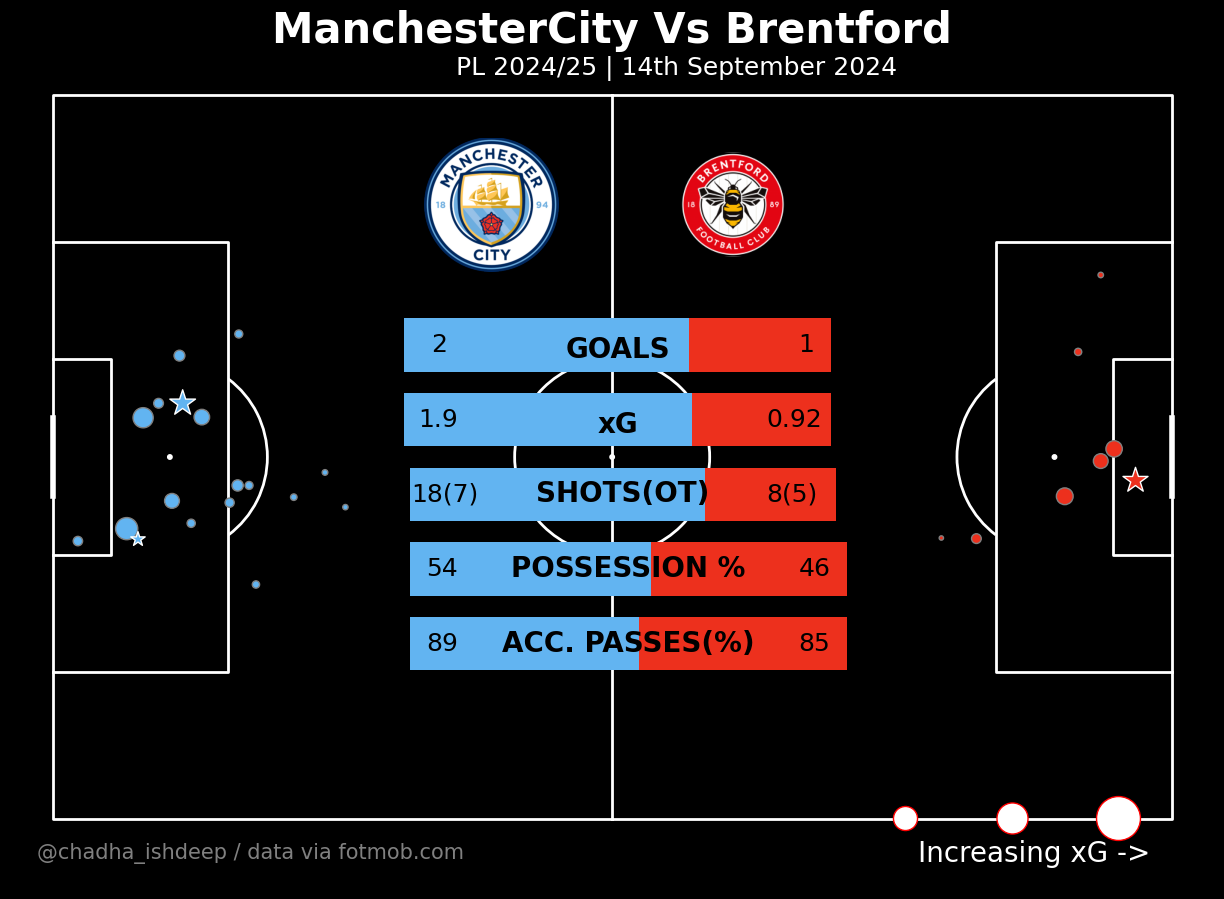

In [53]:
fig, axs = pitch.grid(grid_height=0.9, title_height=0.04, axis=False,
                     endnote_height=0.03, title_space=0, endnote_space=0)  # grid takes up 80% of the figure height


team1 = 'ManchesterCity'
team2 = 'Brentford'
#C:\Users\acer\Documents\GitHub\IndianCitizen\Images\TeamLogos
img_team1 = mpimg.imread(f'C:/Users/acer/Documents/GitHub/IndianCitizen/Images/TeamLogos/{team1}.png')
img_team2 = mpimg.imread(f'C:/Users/acer/Documents/GitHub/IndianCitizen/Images/TeamLogos/{team2}.png')
logo = mpimg.imread('C:/Users/acer/Documents/GitHub/IndianCitizen/Images/IndianCitizen.png')

ax_image = add_image(
    img_team1, fig, left=0.33, bottom=0.7, width=0.15, height=0.15,aspect='equal'
)

ax_image = add_image(
    img_team2, fig, left=0.52, bottom=0.7, width=0.15, height=0.15,aspect='equal'
)

team1_facecolor = '#62b4f1'
team2_facecolor = '#ed301d'


pitch.scatter(80,0.1,s=300,ec='red',color='white',ax=axs['pitch'],zorder=2)
pitch.scatter(90,0.1,s=500,ec='red',color='white',ax=axs['pitch'],zorder=2)
pitch.scatter(100,0.1,s=1000,ec='red',color='white',ax=axs['pitch'],zorder=2)

sc_team1 = pitch.scatter(df_team1.x, df_team1.y, s=df_team1.expectedGoals * 800,
                         ec='grey', color=team1_facecolor, ax=axs['pitch'],zorder=2)
sc_team1_goals = pitch.scatter(df_team1_goals.x, df_team1_goals.y, s=df_team1_goals.expectedGoals * 1000,
                         ec='white', color=team1_facecolor,marker='*', ax=axs['pitch'],zorder=2)
sc_team2 = pitch.scatter(df_team2.x, df_team2.y, s=df_team2.expectedGoals * 800,
                         ec='grey', color=team2_facecolor, ax=axs['pitch'],zorder=2)
sc_team2_goals = pitch.scatter(df_team2_goals.x, df_team2_goals.y, s=df_team2_goals.expectedGoals * 1000,
                         ec='white', color=team2_facecolor,marker='*', ax=axs['pitch'],zorder=2)

fig.set_facecolor('black')


# Set title
axs['pitch'].set_title(f'{team1} Vs {team2}',fontdict={'fontsize': 30, 'weight': 'bold', 'color': 'white'}, loc='center')
# Add subtitle
subtitle_text = "PL 2024/25 | 14th September 2024"
axs['pitch'].text(0.37, 0.98, subtitle_text, ha='left', va='center', transform=axs['pitch'].transAxes, color='white', fontsize=18)


goals_team1 = team1_goals
goals_team2 = team2_goals

# Calculate the width of the rectangle for each team
total_goals = goals_team1 + goals_team2

# Define the minimum width for the rectangles
min_rect_width = 9

# Coordinates for the rectangle
rect_x = 33 # X-coordinate of the left side of the rectangle
rect_y = 42  # Y-coordinate of the top side of the rectangle
rect_width = 40  # Width of the rectangle
rect_height = 5  # Height of the rectangle

# Calculate the width of the rectangle for each team
# Calculate the width of the rectangle for each team
if goals_team1 == 0 and goals_team2 > 0:
    # If the home team scored 0 goals and the away team scored greater than 0
    width_team1 = 0
    width_team2 = 1
elif goals_team1 > 0 and goals_team2 == 0:
    # If the away team scored 0 goals and the home team scored greater than 0
    width_team1 = 1
    width_team2 = 0
elif total_goals > 0:
    # If both teams scored some goals
    width_team1 = max(goals_team1 / total_goals, min_rect_width / rect_width)
    width_team2 = max(goals_team2 / total_goals, min_rect_width / rect_width)
else:
    # Both teams scored 0 goals, set equal width for both
    width_team1 = 0.5
    width_team2 = 0.5


# Create a rectangle patch for team1
rect_team1 = Rectangle((rect_x, rect_y), width_team1 * rect_width, rect_height, facecolor=team1_facecolor,zorder=2)

# Create a rectangle patch for team2
rect_team2 = Rectangle((rect_x + width_team1 * rect_width, rect_y), width_team2 * rect_width, rect_height, facecolor=team2_facecolor,zorder=2)

# Add rectangles to the pitch
axs['pitch'].add_patch(rect_team1)
axs['pitch'].add_patch(rect_team2)

# Calculate the position for 'GOALS' text
goals_text_x = rect_x + width_team1 * rect_width + (width_team2 * rect_width - width_team1 * rect_width) / 2
goals_text_y = rect_y + rect_height / 2

# Add labels for teams' goals
axs['pitch'].text(37, rect_y + rect_height / 2, str(goals_team1), color='black', ha='right', va='center',fontsize=18)
axs['pitch'].text(53, 44, 'GOALS', color='black', ha='center', va='center',fontsize=20,fontproperties=font_manager.FontProperties(weight='bold'),zorder=2)
axs['pitch'].text(70, rect_y + rect_height / 2, str(goals_team2), color='black', ha='left', va='center',fontsize=18)

#### Adding xG

# Calculate the width of the rectangle for each team
total_xG = team1_xg + team2_xg
width_team1_xG = team1_xg / total_xG
width_team2_xG = team2_xg / total_xG

if width_team2_xG < 0.05:
    width_team1_xG = 1
    width_team2_xG = 0.05
elif width_team1_xG < 0.05:
    width_team2_xG = 1
    width_team1_xG = 0.05
    

# Coordinates for the rectangle
xG_rect_x = 33 # X-coordinate of the left side of the rectangle
xG_rect_y = 35 # Y-coordinate of the top side of the rectangle

# Create a rectangle patch for team1
xG_rect_team1 = Rectangle((xG_rect_x, xG_rect_y), width_team1_xG * rect_width, rect_height, facecolor=team1_facecolor,zorder=2)

# Create a rectangle patch for team2
xG_rect_team2 = Rectangle((xG_rect_x + width_team1_xG * rect_width, xG_rect_y), width_team2_xG * rect_width, rect_height, facecolor=team2_facecolor,zorder=2)

# Add rectangles to the pitch
axs['pitch'].add_patch(xG_rect_team1)
axs['pitch'].add_patch(xG_rect_team2)

# Add labels for teams' goals
axs['pitch'].text(38, xG_rect_y + rect_height / 2, str(team1_xg), color='black', ha='right', va='center',fontsize=18)
axs['pitch'].text(53, 37, 'xG', color='black', ha='center', va='center',fontsize=20,fontproperties=font_manager.FontProperties(weight='bold'))
axs['pitch'].text(67, xG_rect_y + rect_height / 2, str(team2_xg), color='black', ha='left', va='center',fontsize=18)


#### Adding Shots
shots_team1 = team1_shots
shots_team2 = team2_shots

shots_team1_ot = team1_shots_ot
shots_team2_ot = team2_shots_ot

# Calculate the width of the rectangle for each team
total_shots = shots_team1 + shots_team2
width_team1_shots = shots_team1 / total_shots
width_team2_shots = shots_team2 / total_shots

if width_team2_shots < 0.05:
    width_team1_shots = 1
    width_team2_shots = 0.05
elif width_team1_shots < 0.05:
    width_team2_shots = 1
    width_team1_shots = 0.05

# Coordinates for the rectangle
shots_rect_x = 33.5 # X-coordinate of the left side of the rectangle
shots_rect_y = 28 # Y-coordinate of the top side of the rectangle

# Create a rectangle patch for team1
shots_rect_team1 = Rectangle((shots_rect_x, shots_rect_y), width_team1_shots * rect_width, rect_height, facecolor=team1_facecolor,zorder=2)

# Create a rectangle patch for team2
shots_rect_team2 = Rectangle((shots_rect_x + width_team1_shots * rect_width, shots_rect_y), width_team2_shots * rect_width, rect_height, facecolor=team2_facecolor,zorder=2)

# Add rectangles to the pitch
axs['pitch'].add_patch(shots_rect_team1)
axs['pitch'].add_patch(shots_rect_team2)

# Calculate the position for 'GOALS' text
shots_text_x = shots_rect_x + width_team1_shots * rect_width + (width_team2_shots * rect_width - width_team1_shots * rect_width) / 2
shots_text_y = shots_rect_y + rect_height / 2

# Add labels for teams' goals
axs['pitch'].text(40, shots_rect_y + rect_height / 2, str(shots_team1) + '(' + str(shots_team1_ot) + ')', color='black', ha='right', va='center',fontsize=18)
axs['pitch'].text(shots_text_x, shots_text_y, 'SHOTS(OT)', color='black', ha='center', va='center',fontsize=20,fontproperties=font_manager.FontProperties(weight='bold'))
axs['pitch'].text(67, shots_rect_y + rect_height / 2, str(shots_team2) + '(' + str(shots_team2_ot) + ')', color='black', ha='left', va='center',fontsize=18)


#### Adding possesion
# Calculate the width of the rectangle for each team
total_possesion = team1_pos + team2_pos
width_team1_possesion = (team1_pos / total_possesion)*1.05
width_team2_possesion = team2_pos / total_possesion

# Coordinates for the rectangle
possesion_rect_x = 33.5 # X-coordinate of the left side of the rectangle
possesion_rect_y = 21 # Y-coordinate of the top side of the rectangle

# Create a rectangle patch for team1
possesion_rect_team1 = Rectangle((possesion_rect_x, possesion_rect_y), width_team1_possesion * rect_width, rect_height, facecolor=team1_facecolor,zorder=2)

# Create a rectangle patch for team2
possesion_rect_team2 = Rectangle((possesion_rect_x + width_team1_possesion * rect_width, possesion_rect_y), width_team2_possesion * rect_width, rect_height, facecolor=team2_facecolor,zorder=2)

# Add rectangles to the pitch
axs['pitch'].add_patch(possesion_rect_team1)
axs['pitch'].add_patch(possesion_rect_team2)

# Calculate the position for 'GOALS' text
possesion_text_x = possesion_rect_x + width_team1_possesion * rect_width + (width_team2_possesion * rect_width - width_team1_possesion * rect_width) / 2
possesion_text_y = possesion_rect_y + rect_height / 2

# Add labels for teams' goals
axs['pitch'].text(38, possesion_rect_y + rect_height / 2, str(team1_pos), color='black', ha='right', va='center',fontsize=18)
axs['pitch'].text(possesion_text_x, possesion_text_y, 'POSSESSION %', color='black', ha='center', va='center',fontsize=20,fontproperties=font_manager.FontProperties(weight='bold'))
axs['pitch'].text(70, possesion_rect_y + rect_height / 2, str(team2_pos), color='black', ha='left', va='center',fontsize=18)


#### Adding Accurate Passes
# Calculate the width of the rectangle for each team
total_acc_passes = team1_acc_passes + team2_acc_passes
width_team1_acc_passes = (team1_acc_passes / total_acc_passes)*1.05
width_team2_acc_passes = team2_acc_passes / total_acc_passes

# Coordinates for the rectangle
acc_passes_rect_x = 33.5 # X-coordinate of the left side of the rectangle
acc_passes_rect_y = 14 # Y-coordinate of the top side of the rectangle

# Create a rectangle patch for team1
acc_passes_rect_team1 = Rectangle((acc_passes_rect_x, acc_passes_rect_y), width_team1_acc_passes * rect_width, rect_height, facecolor=team1_facecolor,zorder=2)

# Create a rectangle patch for team2
acc_passes_rect_team2 = Rectangle((acc_passes_rect_x + width_team1_acc_passes * rect_width, acc_passes_rect_y), width_team2_acc_passes * rect_width, rect_height, facecolor=team2_facecolor,zorder=2)

# Add rectangles to the pitch
axs['pitch'].add_patch(acc_passes_rect_team1)
axs['pitch'].add_patch(acc_passes_rect_team2)

# Calculate the position for 'GOALS' text
acc_passes_text_x = acc_passes_rect_x + width_team1_acc_passes * rect_width + (width_team2_acc_passes * rect_width - width_team1_acc_passes * rect_width) / 2
acc_passes_text_y = acc_passes_rect_y + rect_height / 2

# Add labels for teams' goals
axs['pitch'].text(38, acc_passes_rect_y + rect_height / 2, str(team1_acc_passes), color='black', ha='right', va='center',fontsize=18)
axs['pitch'].text(acc_passes_text_x, acc_passes_text_y, 'ACC. PASSES(%)', color='black', ha='center', va='center',fontsize=20,fontproperties=font_manager.FontProperties(weight='bold'))
axs['pitch'].text(70, acc_passes_rect_y + rect_height / 2, str(team2_acc_passes), color='black', ha='left', va='center',fontsize=18)

endnote_text = "@chadha_ishdeep / data via fotmob.com"
axs['pitch'].annotate(endnote_text, xy=(0.2, 0.01), xycoords='axes fraction',ha='center', va='center', fontsize=15, color='gray')

endnote_text2 = "Increasing xG ->"
axs['pitch'].annotate(endnote_text2, xy=(0.85, 0.01), xycoords='axes fraction',ha='center', va='center', fontsize=20, color='white')

plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/MatchReports/CityHome/14-09-2024/{team1}V{team2}_Report.png',dpi=500,bbox_inches = 'tight',facecolor=background)

## PASSES THAT LEAD TO A SHOT

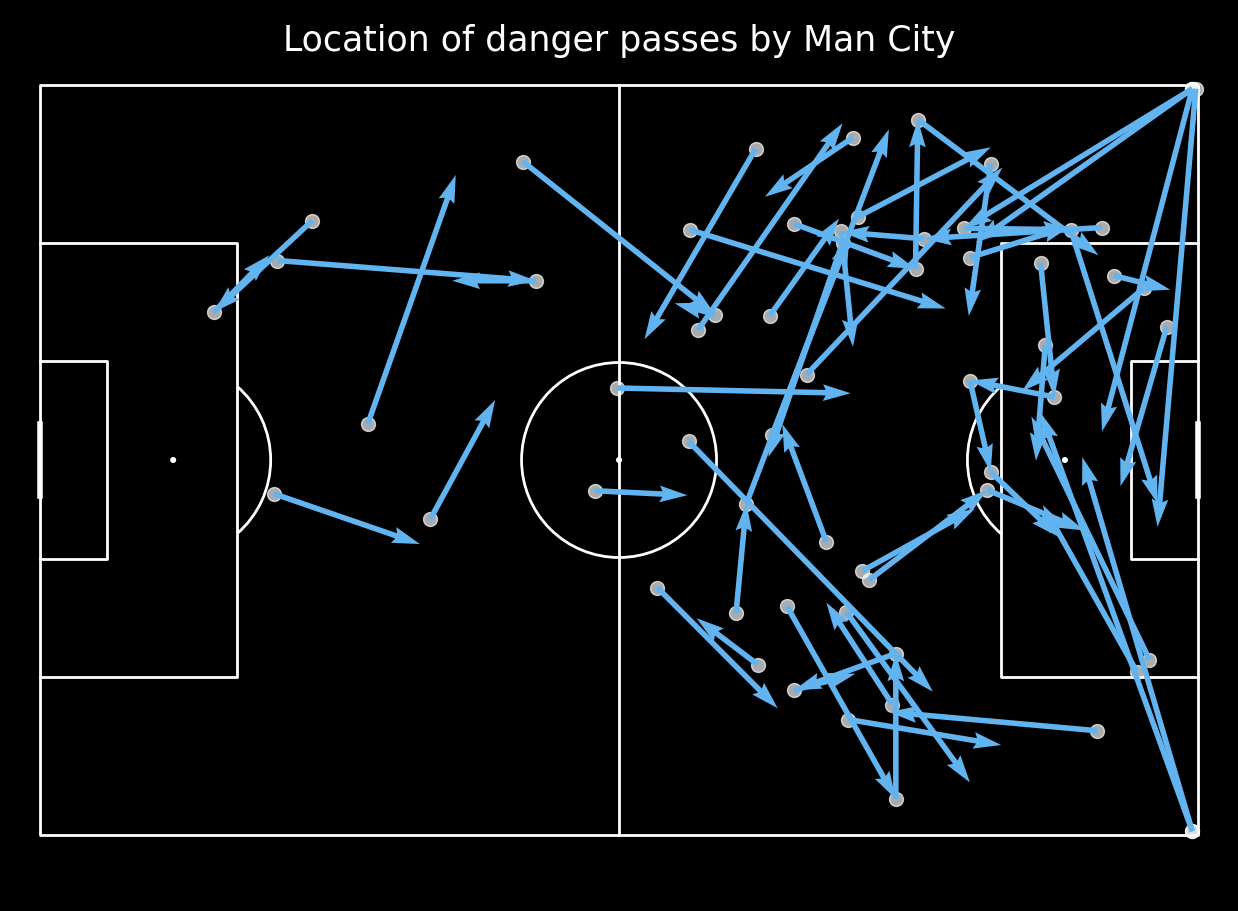

In [84]:
# Assuming the column containing the string values is named 'half'
df_whoscored['period'] = df_whoscored['period'].replace({'FirstHalf': 1, 'SecondHalf': 2})

danger_passes = pd.DataFrame()
team = 'Man City'
for period in [1, 2]:
    #keep only accurate passes by KDB that were not set pieces in this period
    mask_pass = (df_whoscored.team == team) & (df_whoscored.type == "Pass") & (df_whoscored.outcome_type == 'Successful') & (df_whoscored.period == period)
    #keep only necessary columns
    passes = df_whoscored.loc[mask_pass, ["x", "y", "end_x", "end_y", "minute", "second"]]
    #keep only Shots by Man City in this period
    mask_shot = (df_whoscored.team == team) & (df_whoscored.type.isin(["Goal", "MissedShots", "SavedShot"])) & (df_whoscored.period == period)
    #keep only necessary columns
    shots = df_whoscored.loc[mask_shot, ["minute", "second"]]
    #convert time to seconds
    shot_times = shots['minute']*60+shots['second']
    shot_window = 15
    #find starts of the window
    shot_start = shot_times - shot_window
    #condition to avoid negative shot starts
    shot_start = shot_start.apply(lambda i: i if i>0 else (period-1)*45)
    #convert to seconds
    pass_times = passes['minute']*60+passes['second']
    #check if pass is in any of the windows for this half
    pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())

    #keep only danger passes
    danger_passes_period = passes.loc[pass_to_shot]
    #concatenate dataframe with a previous one to keep danger passes from the whole tournament
    danger_passes = pd.concat([danger_passes, danger_passes_period], ignore_index = True)


#plot pitch
pitch = Pitch(pitch_type='opta',pitch_color='black', line_color='white',
              pad_top=4)  # optional stripes
fig, ax = pitch.grid(grid_height=0.9, title_height=0.05, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)


fig.set_facecolor('black')
#scatter the location on the pitch
pitch.scatter(danger_passes.x, danger_passes.y, s=100, color='#F6F5F5', edgecolors='white', linewidth=1, alpha=0.7, ax=ax["pitch"])
#uncomment it to plot arrows
pitch.arrows(danger_passes.x, danger_passes.y, danger_passes.end_x, danger_passes.end_y, color = team2_facecolor, ax=ax['pitch'])
#add title
fig.suptitle('Location of danger passes by ' + team, fontsize = 25,color='white')
#plt.show()
plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/MatchReports/CityAway/31-08-2024/DangerPasses.png',dpi=500,bbox_inches = 'tight',facecolor=background)

## PASSING NETWORKS

In [12]:
html_path = f'C:/Users/acer/Documents/GitHub/IndianCitizen/MatchReports/EUROS-24/{team1}V{team2}/{team1}V{team2}.html'
json_data_txt = extract_json_from_html(html_path)

data = json.loads(json_data_txt)
events_dict, players_df_whoscored, teams_dict = extract_data_from_dict(data)
#players_df_whoscored = update_is_first_eleven(players_df_whoscored)

df_whoscored,passes_df_whoscored = get_passes_df_whoscored(events_dict)

home_team_id = list(teams_dict.keys())[0]  # selected home team
home_passes_between_df_whoscored, home_average_locs_and_count_df_whoscored = get_passes_between_df_whoscored(home_team_id, passes_df_whoscored, players_df_whoscored)

away_team_id = list(teams_dict.keys())[1]  # selected home team
away_passes_between_df_whoscored, away_average_locs_and_count_df_whoscored = get_passes_between_df_whoscored(away_team_id, passes_df_whoscored, players_df_whoscored)

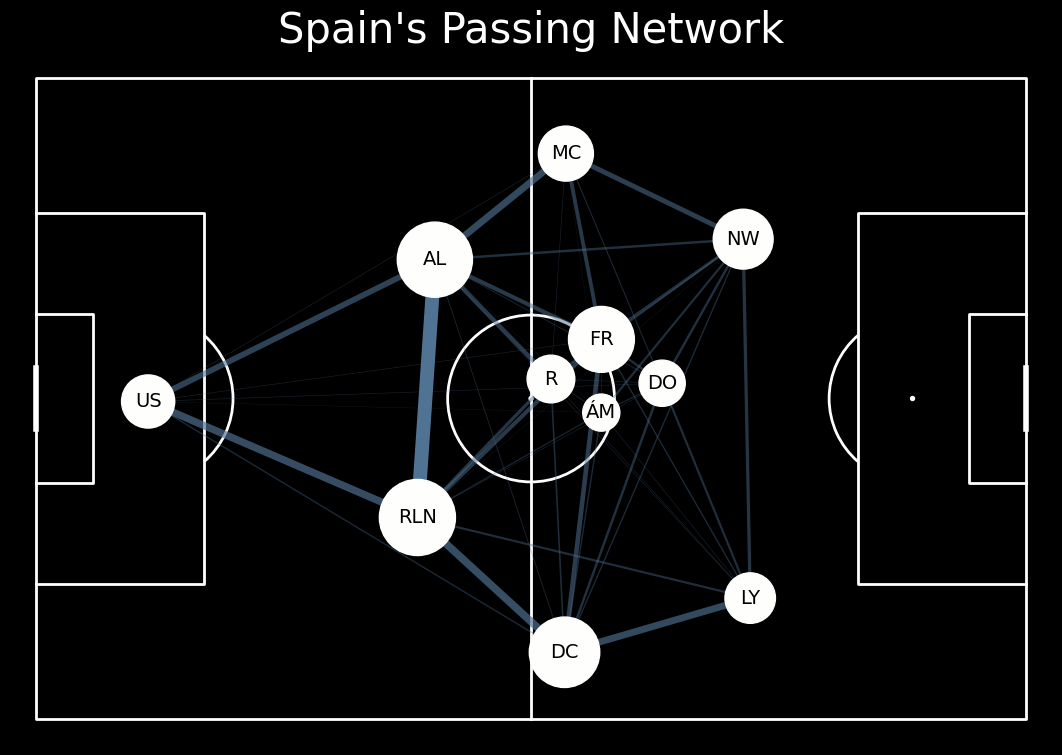

In [13]:
fig,axes = plt.subplots(1, 1, figsize=(16, 9))
fig.set_facecolor("black")
pass_network_visualization(axes, home_passes_between_df_whoscored, home_average_locs_and_count_df_whoscored,team1_facecolor)
axes.set_title(f"{teams_dict[home_team_id]}'s Passing Network", color='white', fontsize=30)

plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/MatchReports/EUROS-24/{team1}V{team2}/{team1}_PassingNetwork.png',dpi=500,bbox_inches = 'tight',facecolor='black')

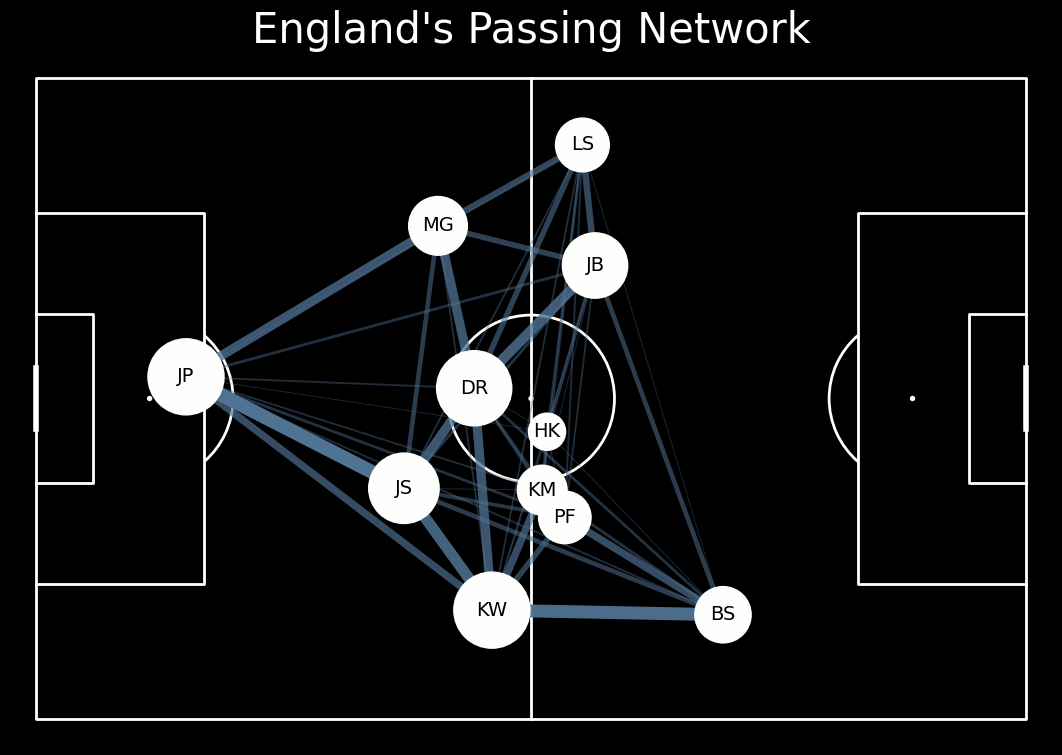

In [14]:
fig,axes = plt.subplots(1, 1, figsize=(16, 9))
fig.set_facecolor("black")
# away team viz
pass_network_visualization(axes, away_passes_between_df_whoscored, away_average_locs_and_count_df_whoscored,team2_facecolor, flipped=False)
axes.set_title(f"{teams_dict[away_team_id]}'s Passing Network", color='white', fontsize=30)

plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/MatchReports/EUROS-24/{team1}V{team2}/{team2}_PassingNetwork.png',dpi=500,bbox_inches = 'tight',facecolor='black')

First Subsitutuion By Brentford was made in minute : 45


C:\Users\acer\AppData\Local\Temp\ipykernel_5572\3246692254.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_firsthalf['pass_recepient'] = None
C:\Users\acer\AppData\Local\Temp\ipykernel_5572\3246692254.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_secondhalf['pass_recepient'] = None


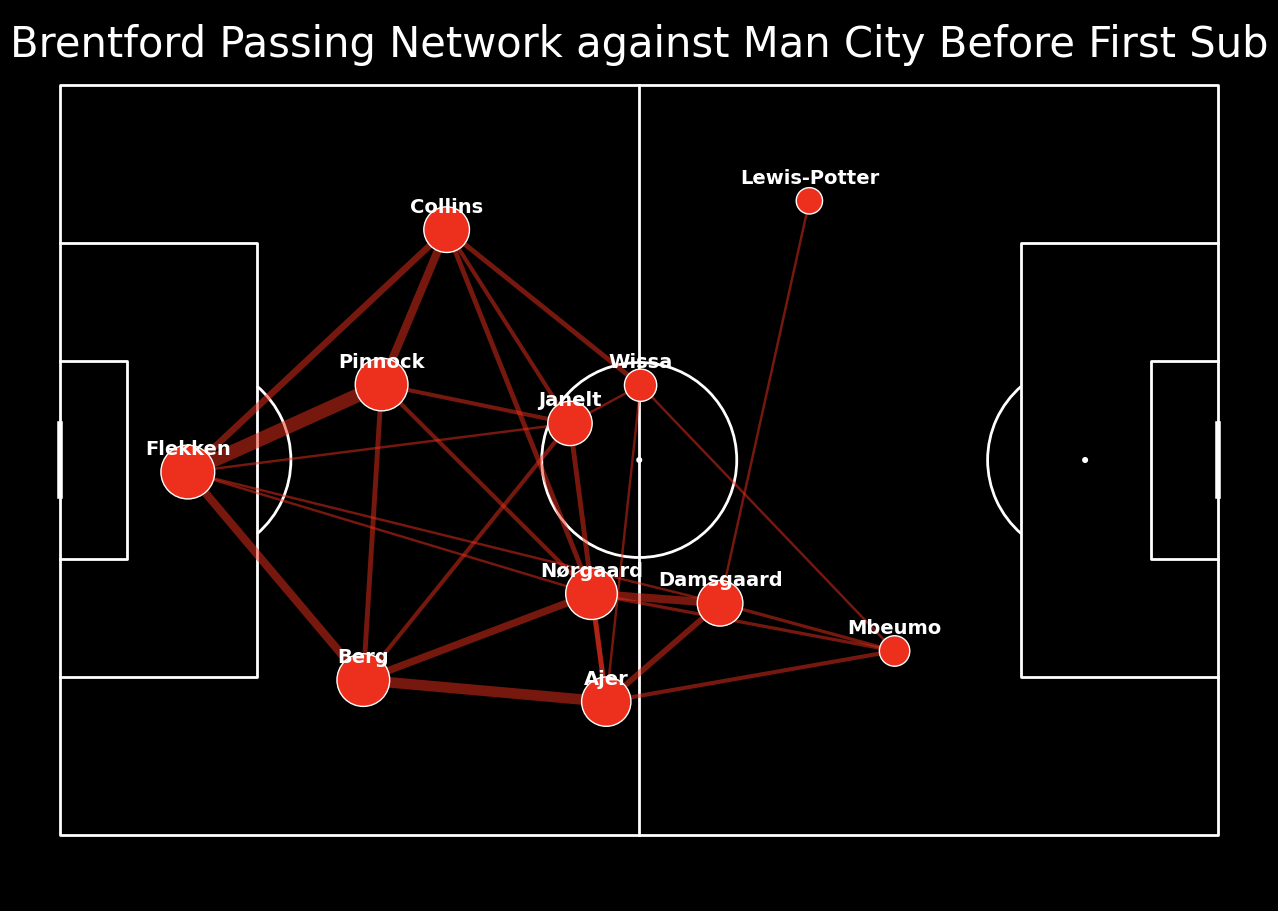

In [27]:
team1 = 'Man City'
team2 = 'Brentford'
first_sub_min = df_whoscored.loc[df_whoscored['type']=='SubstitutionOff'].loc[df_whoscored['team']==team2].iloc[0]['minute']
print(f"First Subsitutuion By {team2} was made in minute : {first_sub_min}")
first_sub_sec = df_whoscored.loc[df_whoscored['type']=='SubstitutionOff'].loc[df_whoscored['team']==team2].iloc[0]['second']

mask_passes = (df_whoscored.type == 'Pass') & (df_whoscored.period == 1) & (df_whoscored.outcome_type == 'Successful')
passes_firsthalf = df_whoscored.loc[mask_passes]
passes_firsthalf.reset_index(inplace=True)
#passes_firsthalf.head()
passes_firsthalf['pass_recepient'] = None

# Check if DataFrame is not empty
if not passes_firsthalf.empty:
    # Loop until the second to last index
    for i in range(len(passes_firsthalf) - 1):
        if passes_firsthalf.team.iloc[i] == passes_firsthalf.team.iloc[i+1]:
            passes_firsthalf.at[i, 'pass_recepient'] = passes_firsthalf.at[i+1, 'player']

mask_passes = (df_whoscored.type == 'Pass') & (df_whoscored.period == 2) & (df_whoscored.outcome_type == 'Successful')
passes_secondhalf = df_whoscored.loc[mask_passes]
passes_secondhalf.reset_index(inplace=True)
#passes_firsthalf.head()
passes_secondhalf['pass_recepient'] = None

# Check if DataFrame is not empty
if not passes_secondhalf.empty:
    # Loop until the second to last index
    for i in range(len(passes_secondhalf) - 1):
        if passes_secondhalf.team.iloc[i] == passes_secondhalf.team.iloc[i+1]:
            passes_secondhalf.at[i, 'pass_recepient'] = passes_secondhalf.at[i+1, 'player']

df_whoscored_pass = pd.concat([passes_firsthalf,passes_secondhalf], ignore_index=True)
#make df_whoscored with successfull passes by England until the first substitution
mask_city = (df_whoscored_pass.team == team2) & (df_whoscored_pass.minute < first_sub_min)
#taking necessary columns
df_whoscored_pass = df_whoscored_pass.loc[mask_city, ['x', 'y', 'end_x', 'end_y', "player", "pass_recepient"]]
df_whoscored_pass["player"] = df_whoscored_pass["player"].apply(lambda x: str(x).split()[-1])
df_whoscored_pass["pass_recepient"] = df_whoscored_pass["pass_recepient"].apply(lambda x: str(x).split()[-1])
df_whoscored_pass.reset_index(inplace=True)

df_whoscored_pass = df_whoscored_pass[df_whoscored_pass['pass_recepient'] != 'None']

scatter_df_whoscored = pd.DataFrame()
for i, name in enumerate(df_whoscored_pass["player"].unique()):
    passx = df_whoscored_pass.loc[df_whoscored_pass["player"] == name]["x"].to_numpy()
    recx = df_whoscored_pass.loc[df_whoscored_pass["pass_recepient"] == name]["end_x"].to_numpy()
    passy = df_whoscored_pass.loc[df_whoscored_pass["player"] == name]["y"].to_numpy()
    recy = df_whoscored_pass.loc[df_whoscored_pass["pass_recepient"] == name]["end_y"].to_numpy()
    scatter_df_whoscored.at[i, "player"] = name
    #make sure that x and y location for each circle representing the player is the average of passes and receptions
    scatter_df_whoscored.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df_whoscored.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
    #calculate number of passes
    scatter_df_whoscored.at[i, "no"] = df_whoscored_pass.loc[df_whoscored_pass["player"] == name].count().iloc[0]

#adjust the size of a circle so that the player who made more passes
scatter_df_whoscored['marker_size'] = (scatter_df_whoscored['no'] / scatter_df_whoscored['no'].max() * 1500)

#counting passes between players
df_whoscored_pass["pair_key"] = df_whoscored_pass.apply(lambda x: "_".join(sorted([x["player"], x["pass_recepient"]])), axis=1)
lines_df_whoscored = df_whoscored_pass.groupby(["pair_key"]).x.count().reset_index()
lines_df_whoscored.rename({'x':'pass_count'}, axis='columns', inplace=True)
#setting a treshold. You can try to investigate how it changes when you change it.
lines_df_whoscored = lines_df_whoscored[lines_df_whoscored['pass_count']>2]

#plot once again pitch and vertices
pitch = Pitch(pitch_type='opta',pitch_color='black', line_color='white',
              pad_top=4)  # optional stripes
fig, ax = pitch.grid(grid_height=0.9, title_height=0.05, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)


fig.set_facecolor('black')
pitch.scatter(scatter_df_whoscored.x, scatter_df_whoscored.y, s=scatter_df_whoscored.marker_size, color=team2_facecolor, edgecolors='white', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)
for i, row in scatter_df_whoscored.iterrows():
    pitch.annotate(row.player, xy=(row.x, row.y+3), c='white', va='center', ha='center', weight = "bold", size=14, ax=ax["pitch"], zorder = 4)

for i, row in lines_df_whoscored.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        #take the average location of players to plot a line between them
        player1_x = scatter_df_whoscored.loc[scatter_df_whoscored["player"] == player1]['x'].iloc[0]
        player1_y = scatter_df_whoscored.loc[scatter_df_whoscored["player"] == player1]['y'].iloc[0]
        player2_x = scatter_df_whoscored.loc[scatter_df_whoscored["player"] == player2]['x'].iloc[0]
        player2_y = scatter_df_whoscored.loc[scatter_df_whoscored["player"] == player2]['y'].iloc[0]
        #print(scatter_df_whoscored.index)
        num_passes = row["pass_count"]
        #adjust the line width so that the more passes, the wider the line
        line_width = (num_passes / lines_df_whoscored['pass_count'].max() * 10)
        #plot lines on the pitch
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=0.5, lw=line_width, zorder=2, color=team2_facecolor, ax = ax["pitch"])

fig.suptitle(f"{team2} Passing Network against {team1} Before First Sub", fontsize = 30,color='white')
plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/MatchReports/CityHome/14-09-2024/{team2}_PassingNetwork.png',dpi=500,bbox_inches = 'tight',facecolor=background)

## PLAYER PASSMAPS

In [28]:
df_whoscored['player'].unique()

array([nan, 'Mikkel Damsgaard', 'Jack Grealish', 'Mark Flekken',
       'Kristoffer Ajer', 'Ilkay Gündogan', 'Christian Nørgaard',
       'Bryan Mbeumo', 'Yoane Wissa', 'Keane Lewis-Potter', 'John Stones',
       'Ederson', 'Kevin De Bruyne', 'Mateo Kovacic', 'Savinho',
       'Kyle Walker', 'Nathan Collins', 'Vitaly Janelt', 'Ethan Pinnock',
       'Sepp van den Berg', 'Manuel Akanji', 'Rico Lewis',
       'Erling Haaland', 'Kevin Schade', 'Rodri', 'Josko Gvardiol',
       'Fábio Carvalho', 'Mads Roerslev', 'Bernardo Silva', 'Rúben Dias',
       'Yehor Yarmoliuk', 'Matheus Nunes'], dtype=object)

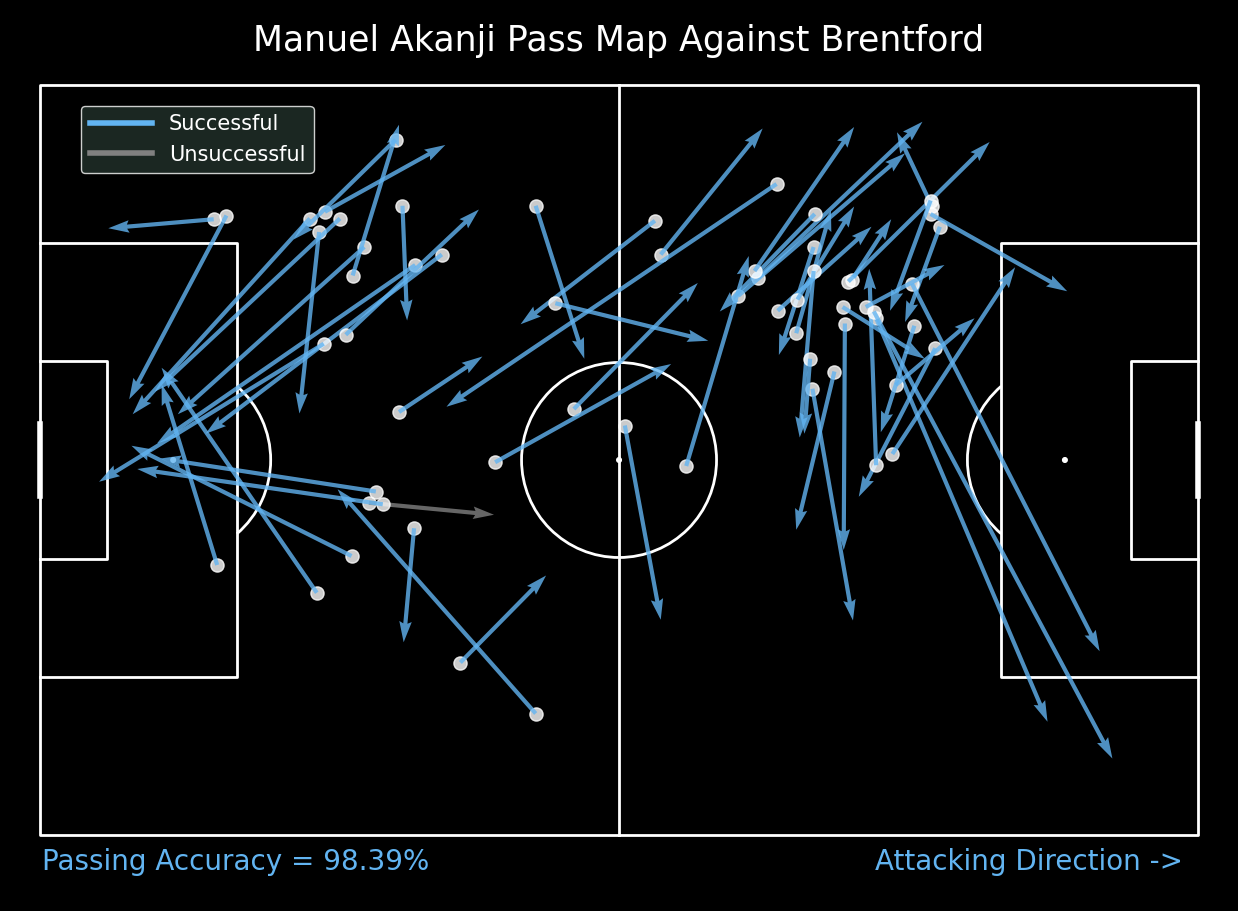

In [32]:
from matplotlib.lines import Line2D
df_whoscored.reset_index(inplace=True)
df_whoscored.rename(columns={'index': 'id'}, inplace=True)
df_whoscored['id'] += 1

player = 'Manuel Akanji'
df_player = df_whoscored.loc[df_whoscored['player'] == player]

selected_col = ['period', 'minute', 'second','x', 'y','end_x', 'end_y','outcome_type']
player_passes_df = df_player.loc[(df_player['type'] == 'Pass') & (df_player['outcome_type'] == 'Successful'), selected_col]
passes_df = df_player.loc[(df_player['type'] == 'Pass'), selected_col]
pass_accuracy = round(player_passes_df.shape[0] / passes_df.shape[0] * 100 , 2)


pitch = Pitch(pitch_type='opta',pitch_color='black', line_color='white',
              pad_top=4)  # optional stripes
fig, ax = pitch.grid(grid_height=0.9, title_height=0.05, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)


fig.set_facecolor('black')


for index, row in passes_df.iterrows():
    if row['outcome_type'] == 'Successful':
        pitch.scatter(row['x'], row['y'], alpha=0.8, s=90, color='white', ax=ax['pitch'])
        pitch.arrows(row['x'], row['y'], row['end_x'], row['end_y'], color=team1_facecolor, ax=ax['pitch'], width=3, alpha=0.8)
    elif row['outcome_type'] == 'Unsuccessful':
        pitch.scatter(row['x'], row['y'], alpha=0.8, s=90, color='white', ax=ax['pitch'])
        pitch.arrows(row['x'], row['y'], row['end_x'], row['end_y'], color='grey', ax=ax['pitch'], width=3, alpha=0.8)

#pitch.scatter(player_passes_df.x, player_passes_df.y, alpha = 0.8, s = 90, color = 'white', ax=ax['pitch'])
#pitch.arrows(player_passes_df.x, player_passes_df.y,player_passes_df.end_x, player_passes_df.end_y, color = team2_facecolor, ax=ax['pitch'],width=3)
legend_elements = [
        Line2D([0], [0], color=team1_facecolor, lw=4, label='Successful'),
        Line2D([0], [0], color='grey', lw=4, label='Unsuccessful')
    ]
ax['pitch'].legend(handles=legend_elements, facecolor='#22312b', handlelength=3, edgecolor='white', fontsize=15, loc='upper left',labelcolor='w',bbox_to_anchor=(0.05, 0.95))
 
fig.suptitle(f"{player} Pass Map Against {team2}", fontsize = 25,color='white')
fig.text(0.05,0.04,f"Passing Accuracy = {pass_accuracy}%",fontsize=20,color=team1_facecolor)
fig.text(0.7,0.04,"Attacking Direction ->",fontsize=20,color=team1_facecolor)
plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/MatchReports/CityHome/14-09-2024/{player}_Passmap.png',dpi=500,bbox_inches = 'tight',facecolor=background)

## Sonar Grid

In [99]:
#df.head()
df_pass = df[(df.type == 'Pass') & (df.team == 'Man City')].copy()
df_pass['success'] = df_pass['outcome_type'] == 'Successful'

In [34]:
pitch = Pitch(pitch_color='black', line_color='white')
angle, distance = pitch.calculate_angle_and_distance(df_pass.x, df_pass.y, df_pass.end_x,
                                                     df_pass.end_y)
# stats for passes
bins = (6, 4, 5)
bs_count_all = pitch.bin_statistic_sonar(df_pass.x, df_pass.y, angle, bins=bins, center=True)
bs_success = pitch.bin_statistic_sonar(df_pass.x, df_pass.y, angle, values=df_pass.success,
                                       statistic='mean', bins=bins, center=True)
bs_distance = pitch.bin_statistic_sonar(df_pass.x, df_pass.y, angle, values=distance,
                                        statistic='mean', bins=bins, center=True)

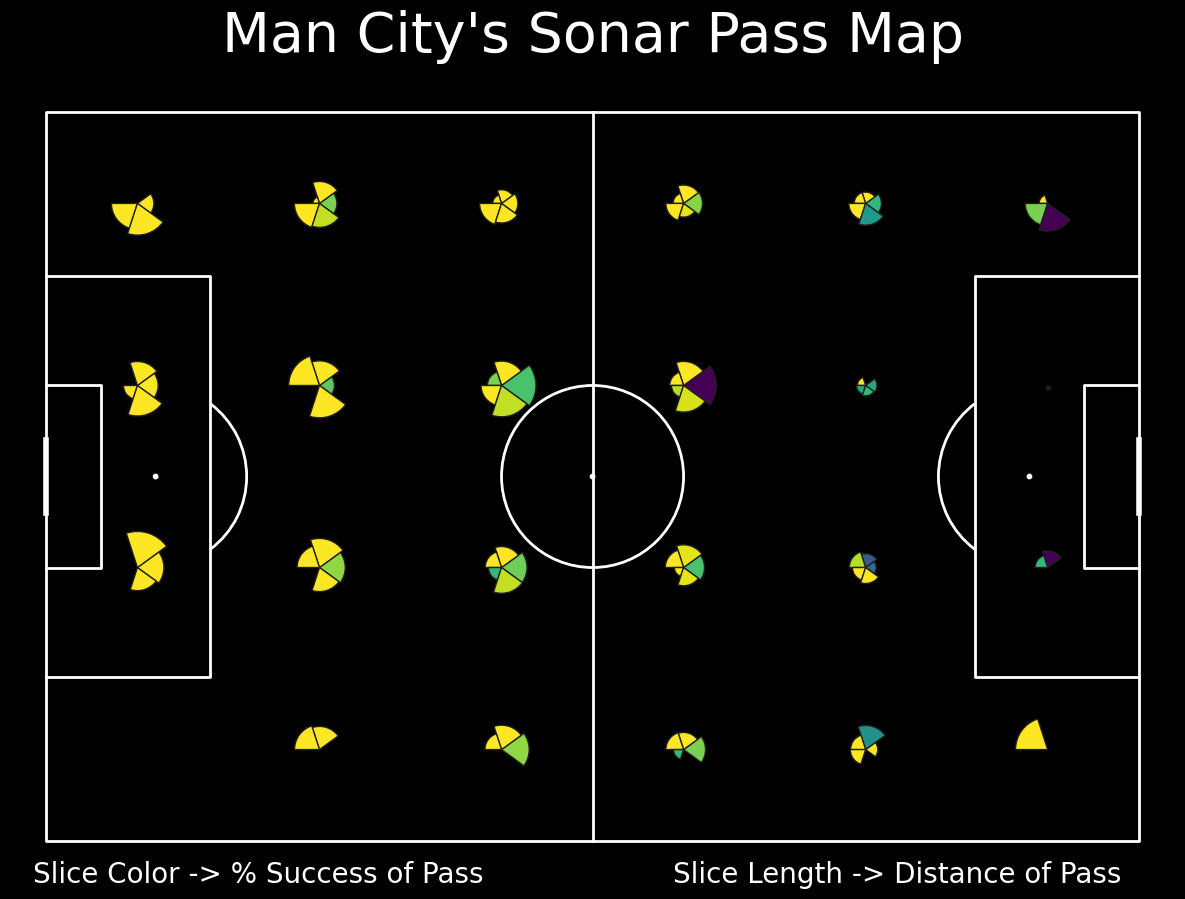

In [48]:
fig, ax = pitch.draw(figsize=(16, 9))
fig.set_facecolor('black')
axs = pitch.sonar_grid(bs_distance,
                       # here we set the color of the slices based on the % success of the pass
                       stats_color=bs_success, cmap='viridis', ec='#202020',
                       # we set the color map to be mapped from 0% to 100%
                       # rather than the default min/max of the values
                       vmin=0, vmax=1,
                       # the axis minimum and maximum are set automatically to the min/max
                       # here we set it explicity to 0 and 50 units
                       rmin=0, rmax=50,
                       zorder=3,  # slices appear above the axis lines
                       width=15,
                       # the size of the sonar axis in data coordinates. Can use height instead
                       ax=ax)

fig.suptitle(f"Man City's Sonar Pass Map", fontsize = 40,color='white')
fig.text(0.15,0.01,"Slice Color -> % Success of Pass",fontsize=20,color='white')
fig.text(0.55,0.01,"Slice Length -> Distance of Pass",fontsize=20,color='white')
plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/MatchReports/CityHome/24-08-2024/SonarPassmap.png',dpi=500,bbox_inches = 'tight',facecolor=background)

## PASSFLOW MAPS

In [104]:
mask_passes_1 = (df_whoscored.type == 'Pass') & (df_whoscored.team == team1)
team1_passes_df = df_whoscored.loc[mask_passes_1]

mask_passes_2 = (df_whoscored.type == 'Pass') & (df_whoscored.team == team2)
team2_passes_df = df_whoscored.loc[mask_passes_2]

In [105]:
team1_passes_df.columns

Index(['id', 'id', 'id', 'league', 'season', 'game', 'id', 'game_id', 'period',
       'minute', 'second', 'expanded_minute', 'type', 'outcome_type',
       'team_id', 'team', 'player_id', 'player', 'x', 'y', 'end_x', 'end_y',
       'goal_mouth_y', 'goal_mouth_z', 'blocked_x', 'blocked_y', 'qualifiers',
       'is_touch', 'is_shot', 'is_goal', 'card_type', 'related_event_id',
       'related_player_id'],
      dtype='object')

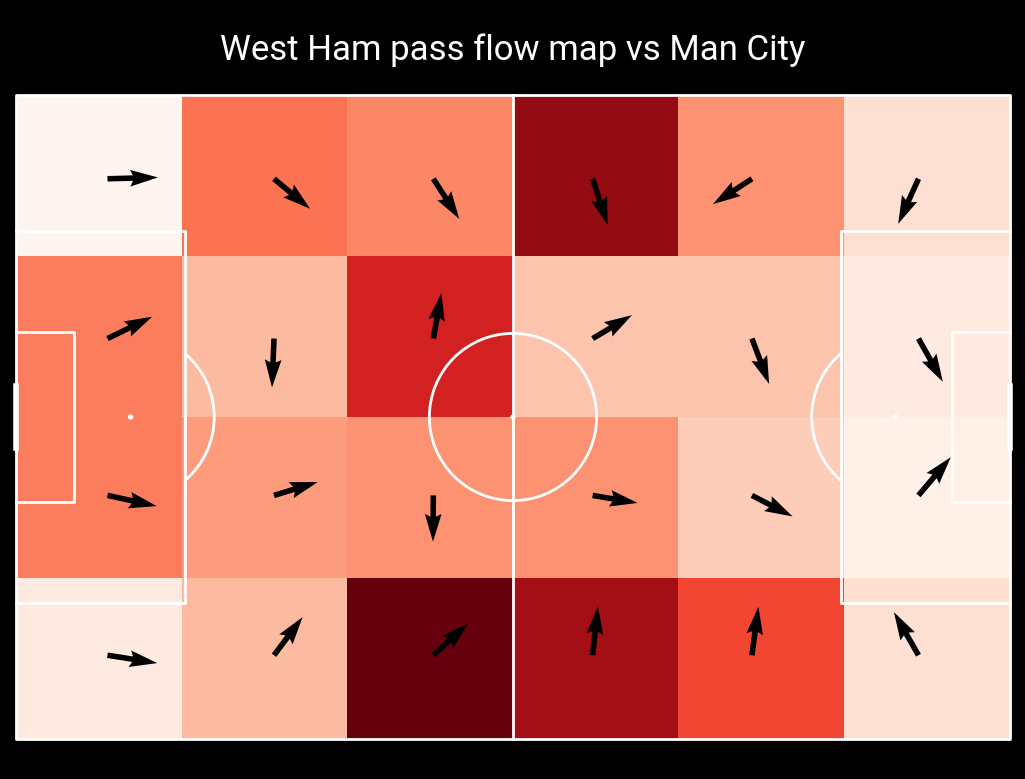

In [106]:
pitch = Pitch(pitch_type='opta', pad_bottom=1, pad_top=1,
              pad_left=1, pad_right=1,
              line_zorder=2, line_color='white', pitch_color='black')
bins = (6, 4)
fig, axs = pitch.grid(figheight=8, endnote_height=0.03, endnote_space=0,
                      title_height=0.1, title_space=0, grid_height=0.82,
                      axis=False)
fig.set_facecolor('black')

# plot the heatmap - darker colors = more passes originating from that square
bs_heatmap = pitch.bin_statistic(team1_passes_df.x, team1_passes_df.y, statistic='count', bins=bins)
hm = pitch.heatmap(bs_heatmap, ax=axs['pitch'], cmap='Reds')
# plot the pass flow map with a single color ('black') and length of the arrow (5)
fm = pitch.flow(team1_passes_df.x, team1_passes_df.y, team1_passes_df.end_x, team1_passes_df.end_y,
                color='black', arrow_type='same',
                arrow_length=5, bins=bins, ax=axs['pitch'])

# title / endnote
font = FontManager()  # default is loading robotto font from google fonts
axs['title'].text(0.5, 0.5, f'{team1} pass flow map vs {team2}',
                  fontsize=25, fontproperties=font.prop,color='white', va='center', ha='center')
#axs['endnote'].text(1, 0.5, '@indian_citizen',
                    #fontsize=18, fontproperties=font.prop,color='white', va='center', ha='right')

plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/MatchReports/CityAway/31-08-2024/{team1}_Passmap.png',dpi=500,bbox_inches = 'tight',facecolor=background)

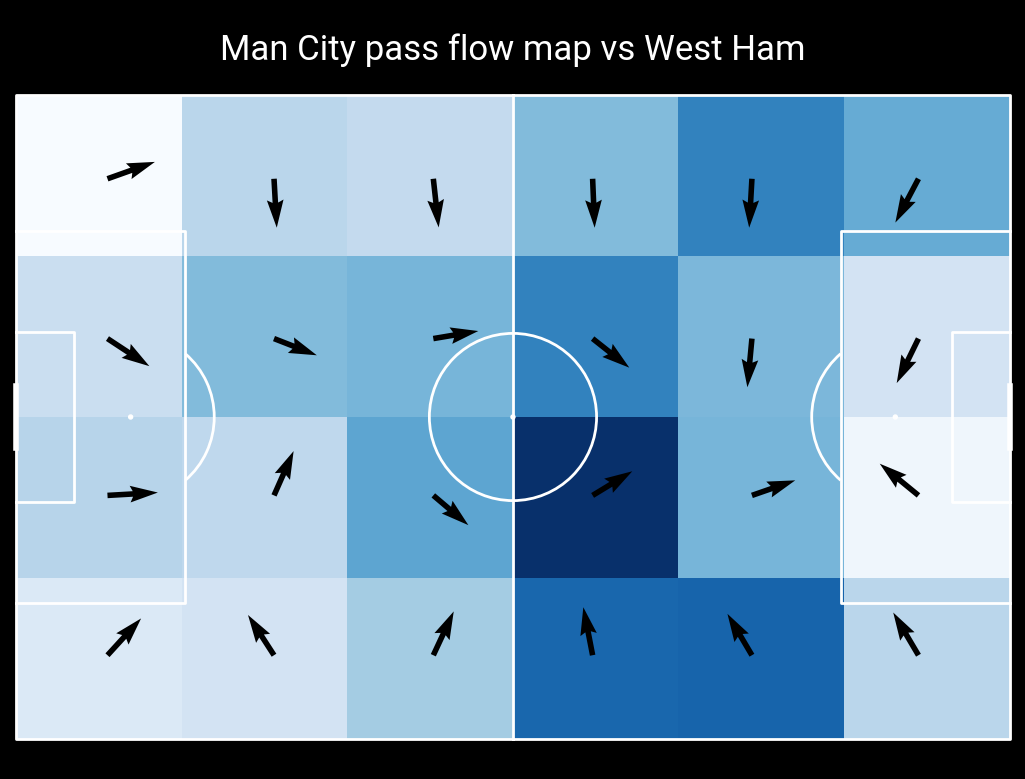

In [107]:
pitch = Pitch(pitch_type='opta', pad_bottom=1, pad_top=1,
              pad_left=1, pad_right=1,
              line_zorder=2, line_color='white', pitch_color='black')
bins = (6, 4)
fig, axs = pitch.grid(figheight=8, endnote_height=0.03, endnote_space=0,
                      title_height=0.1, title_space=0, grid_height=0.82,
                      axis=False)
fig.set_facecolor('black')

# plot the heatmap - darker colors = more passes originating from that square
bs_heatmap = pitch.bin_statistic(team2_passes_df.x, team2_passes_df.y, statistic='count', bins=bins)
hm = pitch.heatmap(bs_heatmap, ax=axs['pitch'], cmap='Blues')
# plot the pass flow map with a single color ('black') and length of the arrow (5)
fm = pitch.flow(team2_passes_df.x, team2_passes_df.y, team2_passes_df.end_x, team2_passes_df.end_y,
                color='black', arrow_type='same',
                arrow_length=5, bins=bins, ax=axs['pitch'])

# title / endnote
font = FontManager()  # default is loading robotto font from google fonts
axs['title'].text(0.5, 0.5, f'{team2} pass flow map vs {team1}',
                  fontsize=25, fontproperties=font.prop,color='white', va='center', ha='center')
#axs['endnote'].text(1, 0.5, '@indian_citizen',
                    #fontsize=18, fontproperties=font.prop,color='white', va='center', ha='right')

plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/MatchReports/CityAway/31-08-2024/{team2}_Passmap.png',dpi=500,bbox_inches = 'tight',facecolor=background)

## PLAYER ANALYSIS - PassMap , ShotMap , TouchMap

In [41]:
def player_shotmap(ax,df,player):
    for index,row in df.iterrows():
        if (row['player'] == player):
            if row['type'] == 'Goal':
                pitch.scatter(row['y'], row['x'], color='green', s=1000, edgecolor='white', linewidth=2, alpha=0.9,marker='*',ax=ax)
            elif row['type'] == 'SavedShot':
                pitch.scatter(row['y'], row['x'], color='blue', s=300, edgecolor='white', linewidth=2, alpha=0.9,marker='o',ax=ax)
            elif row['type'] == 'MissedShots':
                pitch.scatter(row['y'], row['x'], color='red', s=300, edgecolor='white', linewidth=2, alpha=0.9,marker='x',ax=ax)
            elif row['type'] == 'ShotOnPost':
                pitch.scatter(row['y'], row['x'], color='yellow', s=300, edgecolor='white', linewidth=2, alpha=0.9,marker='x',ax=ax)

def player_passmap(ax,df,player):
    for index,row in df.iterrows():
        if ((row['player'] == player) & (row['type'] == 'Pass')):
            if row['outcome_type'] == 'Successful':
                pitch.scatter(row['y'], row['x'], alpha=0.8, s=90, color='white', ax=ax)
                pitch.arrows(row['y'], row['x'], row['end_y'], row['end_x'], color=team1_facecolor, ax=ax, width=3, alpha=0.8)
            if row['outcome_type'] == 'Unsuccessful':
                pitch.scatter(row['y'], row['x'], alpha=0.8, s=90, color='white', ax=ax)
                pitch.arrows(row['y'], row['x'], row['end_y'], row['end_x'], color='grey', ax=ax, width=3, alpha=0.5)

def player_heatmap(df, player):
    df_filtered = df[
        (df['player'] == player) &
        (df['type'].isin(['Pass', 'BallRecovery', 'BallTouch', 'Clearance', 'Goal', 'SavedShot', 'MissedShots']))
    ]
    return df_filtered

In [42]:
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
flamingo_cmap = LinearSegmentedColormap.from_list("Flamingo - 100 colors",
                                                  ['#e3aca7', '#c03a1d'], N=100)
def player_report(player):
    FIGWIDTH = 14
    FIGHEIGHT = 8
    NROWS = 1
    NCOLS = 3
    SPACE = 0.09
    MAX_GRID = 0.95
    #pitch = VerticalPitch(pitch_type='opta',half=False,line_alpha=0.5, goal_alpha=0.8,corner_arcs=False,goal_type='circle',pitch_color='black')
    #fig, axs = pitch.grid(ncols=3,figheight=16,figwidth=9,title_height=0.08, title_space=0.03,endnote_space=0,axis=False)
    pitch = VerticalPitch(pitch_type='opta',pad_top=1, pad_bottom=1,
                      pad_left=1, pad_right=1,
                      pitch_color='black', stripe=False, line_color='white',line_alpha=0.5, goal_alpha=0.8,corner_arcs=False,goal_type='circle')
    GRID_WIDTH, GRID_HEIGHT = pitch.grid_dimensions(figwidth=FIGWIDTH, figheight=FIGHEIGHT,
                                                nrows=NROWS, ncols=NCOLS,
                                                max_grid=MAX_GRID, space=SPACE)
    TITLE_HEIGHT = 0.1
    ENDNOTE_HEIGHT = MAX_GRID - (GRID_HEIGHT + TITLE_HEIGHT)

    fig, axs = pitch.grid(figheight=FIGHEIGHT, grid_width=GRID_WIDTH, grid_height=GRID_HEIGHT,
                     space=SPACE, ncols=NCOLS, nrows=NROWS, title_height=TITLE_HEIGHT,
                     endnote_height=ENDNOTE_HEIGHT, axis=False)
    fig.set_facecolor("black")
    # title text
    axs['title'].text(0.5, 0.65, f"{player}'s Match Report", fontsize=25,va='center', ha='center',color='white')
    
    ## SHOTMAP
    ax_title_shotmap = axs['pitch'][0].set_title('ShotMap', fontsize = 17,color='white')
    # Set up the legend
    player_shotmap(axs['pitch'][0],df_whoscored,player)

    legend_elements_1 = [
        Line2D([0], [0], color='green', lw=1,marker='*',markersize=15, label='Goal'),
        Line2D([0], [0], color='blue', lw=1,marker='x',markersize=15, label='Saved'),
        Line2D([0], [0], color='red', lw=1,marker='x',markersize=15, label='Miss'),
        Line2D([0], [0], color='yellow', lw=1,marker='x',markersize=15, label='Post')
    ]
    axs['pitch'][0].legend(handles=legend_elements_1, facecolor='#22312b', handlelength=3, edgecolor='white', fontsize=15, loc='lower left',labelcolor='w',bbox_to_anchor=(0.1, 0.1))
    #axs['pitch'][0].legend(facecolor='#22312b', handlelength=3, edgecolor='white', fontsize=16, loc='upper left',labelcolor='w',bbox_to_anchor=(0.06, 0.95))

    ## PASSMAP
    ax_title_passmap = axs['pitch'][1].set_title('PassMap', fontsize = 17,color='white')
    # Set up the legend
    #pass_accuracy = passes_df.loc[(passes_df['name'] == player) & (passes_df['outcomeType'] == 'Successful')].shape[0] / passes_df.loc[(passes_df['name'] == player)].shape[0] 
    #pass_accuracy = round(pass_accuracy * 100,2)
    
    player_passmap(axs['pitch'][1],df_whoscored,player)

    legend_elements_2 = [
        Line2D([0], [0], color=team1_facecolor, lw=4, label='Successful'),
        Line2D([0], [0], color='grey', lw=4, label='Unsuccessful')
    ]
    axs['pitch'][1].legend(handles=legend_elements_2, facecolor='#22312b', handlelength=3, edgecolor='white', fontsize=15, loc='upper left',labelcolor='w',bbox_to_anchor=(0.05, 0.2))
    #axs['pitch'][1].text(0.9,0.9,f"Passing Accuracy = {pass_accuracy}%",fontsize=20,color=team1_facecolor,zorder=5)
    ## HEATMAP
    ax_title_heatmap = axs['pitch'][2].set_title('TouchMap', fontsize = 17,color='white')
    #player_heatmap(axs['pitch'][2],df_players,player)
    df = player_heatmap(df_whoscored,player)
    pitch.kdeplot(df.x, df.y, ax=axs['pitch'][2], cmap='Purples',fill=True,levels=10,alpha=0.6)
    #pitch.scatter(df.x, df.y,color='green', s=500, edgecolor='white', linewidth=2, alpha=0.9,marker='o',ax=axs['pitch'][2])

    plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/MatchReports/CityHome/14-09-2024/{player}Report.png',dpi=500,bbox_inches = 'tight',facecolor=background)
    

In [43]:
df_whoscored['player'].unique()

array([nan, 'Mikkel Damsgaard', 'Jack Grealish', 'Mark Flekken',
       'Kristoffer Ajer', 'Ilkay Gündogan', 'Christian Nørgaard',
       'Bryan Mbeumo', 'Yoane Wissa', 'Keane Lewis-Potter', 'John Stones',
       'Ederson', 'Kevin De Bruyne', 'Mateo Kovacic', 'Savinho',
       'Kyle Walker', 'Nathan Collins', 'Vitaly Janelt', 'Ethan Pinnock',
       'Sepp van den Berg', 'Manuel Akanji', 'Rico Lewis',
       'Erling Haaland', 'Kevin Schade', 'Rodri', 'Josko Gvardiol',
       'Fábio Carvalho', 'Mads Roerslev', 'Bernardo Silva', 'Rúben Dias',
       'Yehor Yarmoliuk', 'Matheus Nunes'], dtype=object)

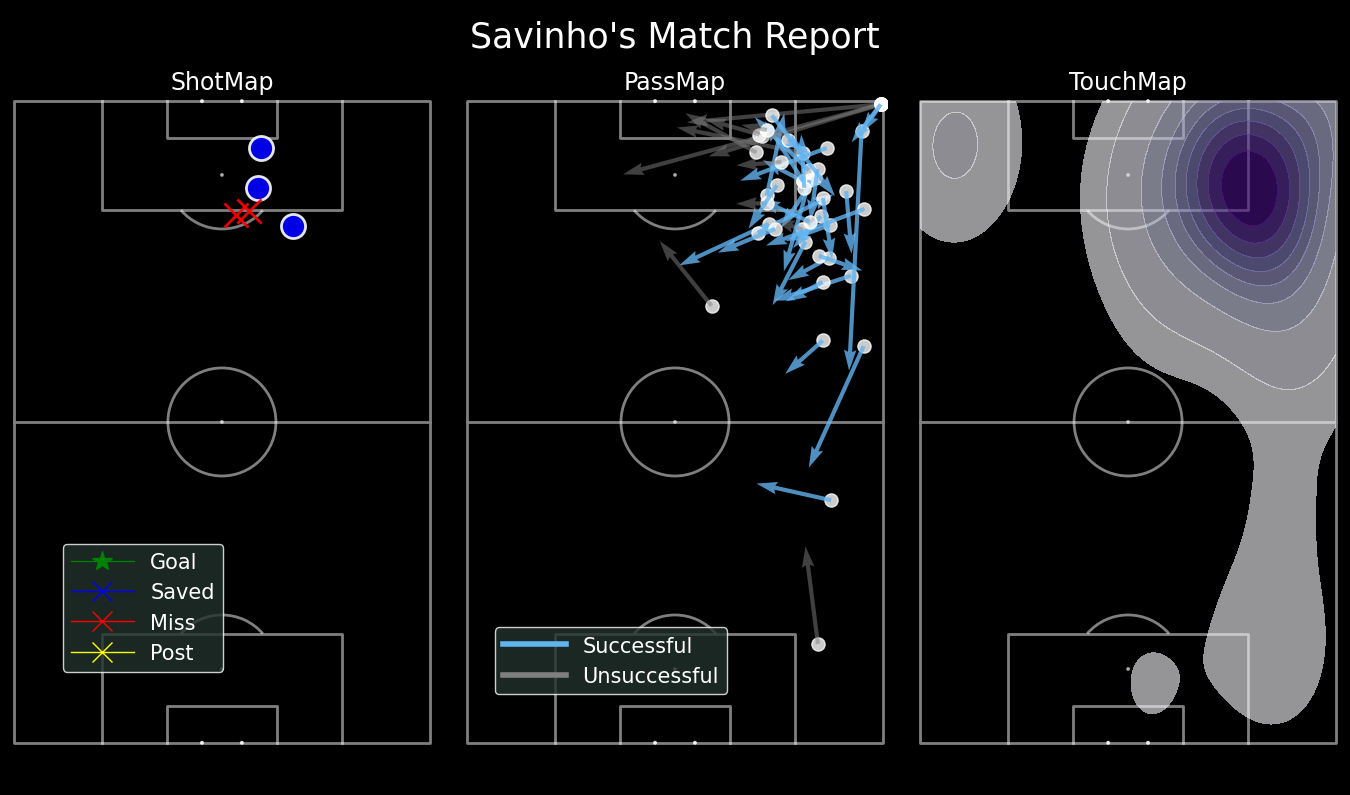

In [44]:
player_report('Savinho')

## xG FLOW CHART

In [45]:
team1Id, team2Id = df_shots.teamId.unique()

In [46]:
df_xG = df_shots[['teamId','playerName','min','expectedGoals','expectedGoalsOnTarget','eventType','minAdded','isOwnGoal','situation']]
df_xG['teamName'] = df_xG.apply(lambda x: hometeam if x['teamId'] == team2Id else (awayteam if x['teamId'] == team1Id else None), axis=1)

df_xG['cumulative_xG'] = df_xG.groupby('teamName')['expectedGoals'].cumsum()
df_xG['cumulative_xGOT'] = df_xG.groupby('teamName')['expectedGoalsOnTarget'].cumsum()

df_xG['half'] = df_xG['min'].apply(lambda x: 1 if x <= 45 else 2)

df_xG['min'] = df_xG['min'] + df_xG['minAdded'].fillna(0)

C:\Users\acer\AppData\Local\Temp\ipykernel_5572\3426859044.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xG['teamName'] = df_xG.apply(lambda x: hometeam if x['teamId'] == team2Id else (awayteam if x['teamId'] == team1Id else None), axis=1)
C:\Users\acer\AppData\Local\Temp\ipykernel_5572\3426859044.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xG['cumulative_xG'] = df_xG.groupby('teamName')['expectedGoals'].cumsum()
C:\Users\acer\AppData\Local\Temp\ipykernel_5572\3426859044.py:5: SettingWit

Text(0.75, 0.0, 'Data Source : Opta')

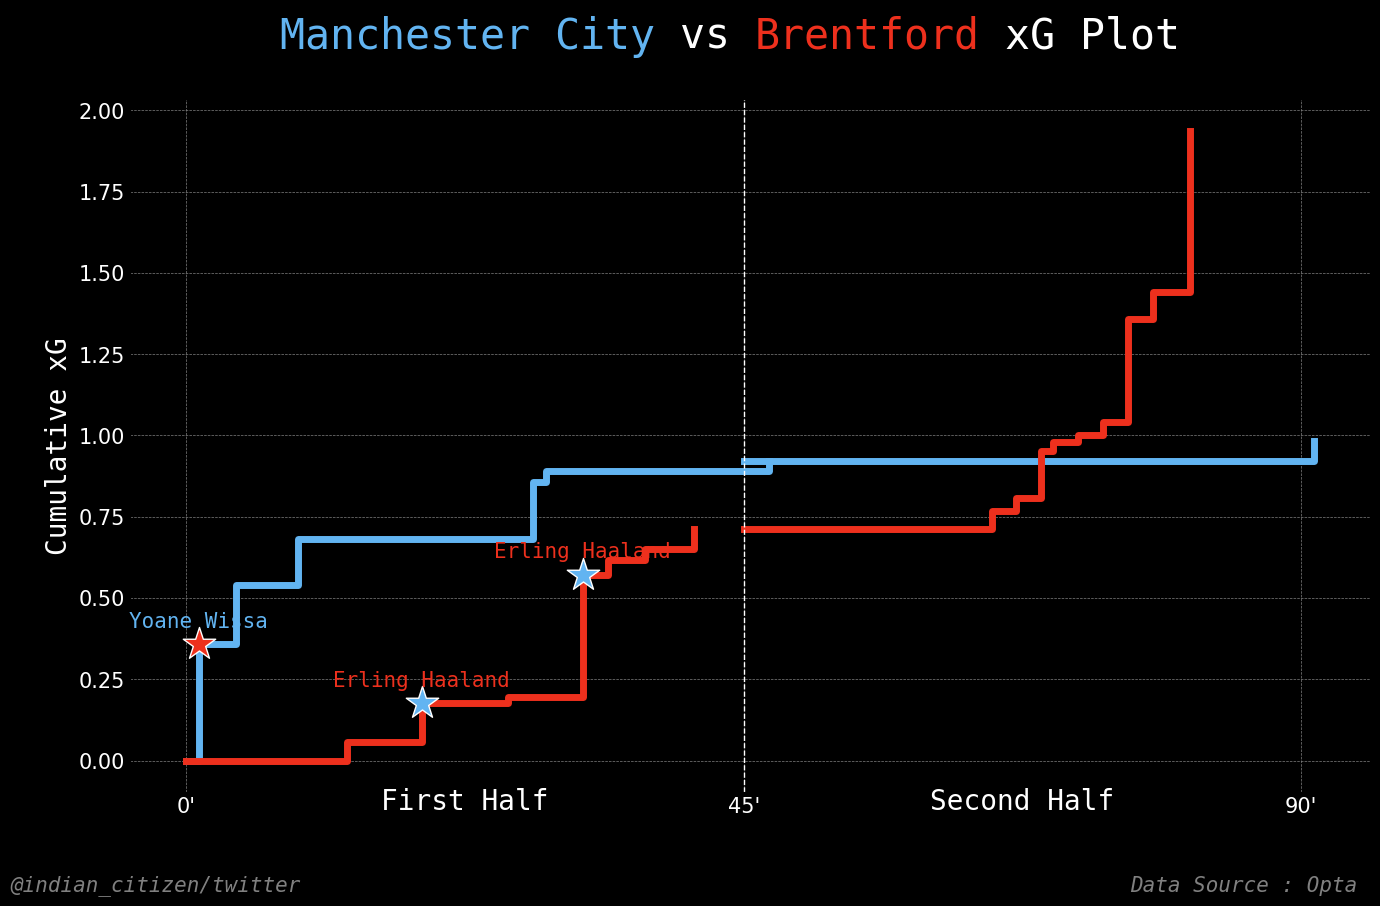

In [48]:
fig, ax = plt.subplots(figsize=(16, 9))
fig.set_facecolor('black')
ax.set_facecolor('black')
# Plot the xG for each team by half
# We want to make it so the lines both start at 0

for team in df_xG['teamName'].unique():
    
    team_df = df_xG[df_xG['teamName'] == team]
    
    # add a 0 xG row at the start of the match
    team_df = pd.concat([pd.DataFrame({'teamName': team, 'min': 0, 'expectedGoals': 0, 'eventType': 'Goal', 'cumulative_xG': 0, 'half': 1}, index=[0]), team_df])
    
    # Also add a row at the beginning of the second half to make the lines start where the first half ended
    team_df = pd.concat([team_df[team_df['half'] == 1], pd.DataFrame({'teamName': team, 'min': 45, 'expectedGoals': 0, 'eventType': 'Goal', 'cumulative_xG': team_df[team_df['half'] == 1]['cumulative_xG'].iloc[-1], 'half': 2}, index=[0]), team_df[team_df['half'] == 2]])

    for half in team_df['half'].unique():
        half_df = team_df[team_df['half'] == half]
        ax.plot(
            half_df['min'], 
            half_df['cumulative_xG'], 
            label=team, 
            drawstyle='steps-post',
            c=team2_facecolor if team == hometeam else team1_facecolor,
            linewidth=5
        )   
        

# We Can add a scatter plot to show the goals
for team in df_xG['teamName'].unique():
    team_df = df_xG[(df_xG['teamName'] == team) & (df_xG['eventType'] == 'Goal')].to_dict(orient='records')
    for x in team_df:
        ax.scatter(
            x['min'], 
            x['cumulative_xG'], 
            c=team1_facecolor if team == hometeam else team2_facecolor,
            edgecolor='white',
            s=600,
            marker='*',
            # We want the goals to be on top of the lines
            zorder=5
        )
        
        # add a label to the goals for the player who scored
        ax.text(
            x['min'], 
            x['cumulative_xG'] + .07, 
            x['playerName'], 
            ha='center', 
            va='center',
            c=team2_facecolor if team == hometeam else team1_facecolor,
            fontfamily='monospace', 
            fontsize=15,
            zorder=10
        )
        
# Let's label the x axis with first and second half
ax.set_xticks([0, 45, 90])
ax.set_xticklabels(['0\'', '45\'', '90\''])

# Lets add the actual words "First Half" and "Second Half" to the plot under the x axis
ax.text(22.5, -.15, 'First Half', ha='center', fontfamily='monospace', fontsize=20,color='white')
ax.text(67.5, -.15, 'Second Half', ha='center', fontfamily='monospace', fontsize=20,color='white')
#ax.text(107.5, -.25, 'Extra Time', ha='center', fontfamily='monospace', fontsize=20,color='white')

# Let's label the y axis with the cumulative xG
ax.set_ylabel('Cumulative xG', fontfamily='monospace', fontsize=20,color='white')

# Let's get rid of the right and top spines
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)

ax.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='both', length=0)

ax.tick_params(axis='x', colors='white', labelsize=15)
ax.tick_params(axis='y', colors='white', labelsize=15)

ax.axvline(x=45, color='white', linestyle='--', linewidth=1)


# Let's change the color of the title to show which team is which using the highlight-text package
from highlight_text import fig_text

fig_text(
    0.5,
    0.95,
    '<Manchester City> vs <Brentford> xG Plot', 
    fontsize=30, 
    ha='center', 
    va='center', 
    ax=ax,
    color='white',
    fontfamily='monospace', 
    highlight_textprops=[{'color': team1_facecolor}, {'color': team2_facecolor}]
)


# Now let's add a twitter @ to the bottom left of the plot
fig.text(
    0.05, 
    0.00, 
    '@indian_citizen/twitter', 
    fontsize=15, 
    fontstyle='oblique', 
    fontfamily='monospace', 
    color='grey'
)

fig.text(
    0.75, 
    0.00, 
    'Data Source : Opta', 
    fontsize=15, 
    fontstyle='oblique', 
    fontfamily='monospace', 
    color='grey'
)

#plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/MatchReports/CityAway/31-08-2024/{team1}V{team2}_xGReport.png',dpi=500,bbox_inches = 'tight',facecolor=background)